# 🚀 Índices Sintéticos basados en Embeddings Topológicos

## Objetivo Principal
**¿Podemos construir índices sintéticos basados en embeddings topológicos que superen al S&P500 en rendimiento y estabilidad?**

### Metodología
1. **Embeddings Topológicos**: Usar TDA para agrupar acciones con patrones similares
2. **Índices Topológicos**: Crear índices basados en similaridad topológica (no aleatoria)
3. **Predicción de Cambios**: Detectar ruptures y predecir cambios estructurales
4. **Evaluación**: Comparar rendimiento vs S&P500 y análisis de resiliencia

---

In [13]:
# =======================================================
# 📦 IMPORTS Y CONFIGURACIÓN INICIAL
# =======================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
from bs4 import BeautifulSoup
warnings.filterwarnings('ignore')

# Datos financieros
import yfinance as yf
from datetime import datetime, timedelta

# Machine Learning
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

# TDA
import ripser
from persim import plot_diagrams
from ripser import ripser
try:
    from persim.images import PersistenceImager
except:
    print("⚠️ PersistenceImager no disponible, usaremos alternativa")

# Detección de cambios
import ruptures as rpt

# Visualización avanzada
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Configuración
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
np.random.seed(42)

print("✅ Librerías importadas correctamente")
print("📅 Configuración inicial completada")

✅ Librerías importadas correctamente
📅 Configuración inicial completada


In [14]:
WINDOW_SIZE = 30  # días para sliding windows
OVERLAP = 0     # días de solapamiento

🏗️ CONSTRUYENDO DATASET TEMPORAL FORMALIZADO
Found 503 tickers
📥 Descargando datos históricos (2015-01-01 a 2024-01-01)...
Found 503 tickers
📥 Descargando datos históricos (2015-01-01 a 2024-01-01)...



2 Failed downloads:
['GEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1420088400, endDate = 1704085200")')
['GS']: Timeout('Failed to perform, curl: (28) Operation timed out after 10006 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['GEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1420088400, endDate = 1704085200")')
['GS']: Timeout('Failed to perform, curl: (28) Operation timed out after 10006 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


📊 Dataset final: 2264 días, 110 acciones
📅 Período: 2015-01-02 a 2023-12-29
✅ Dataset temporal formalizado completado


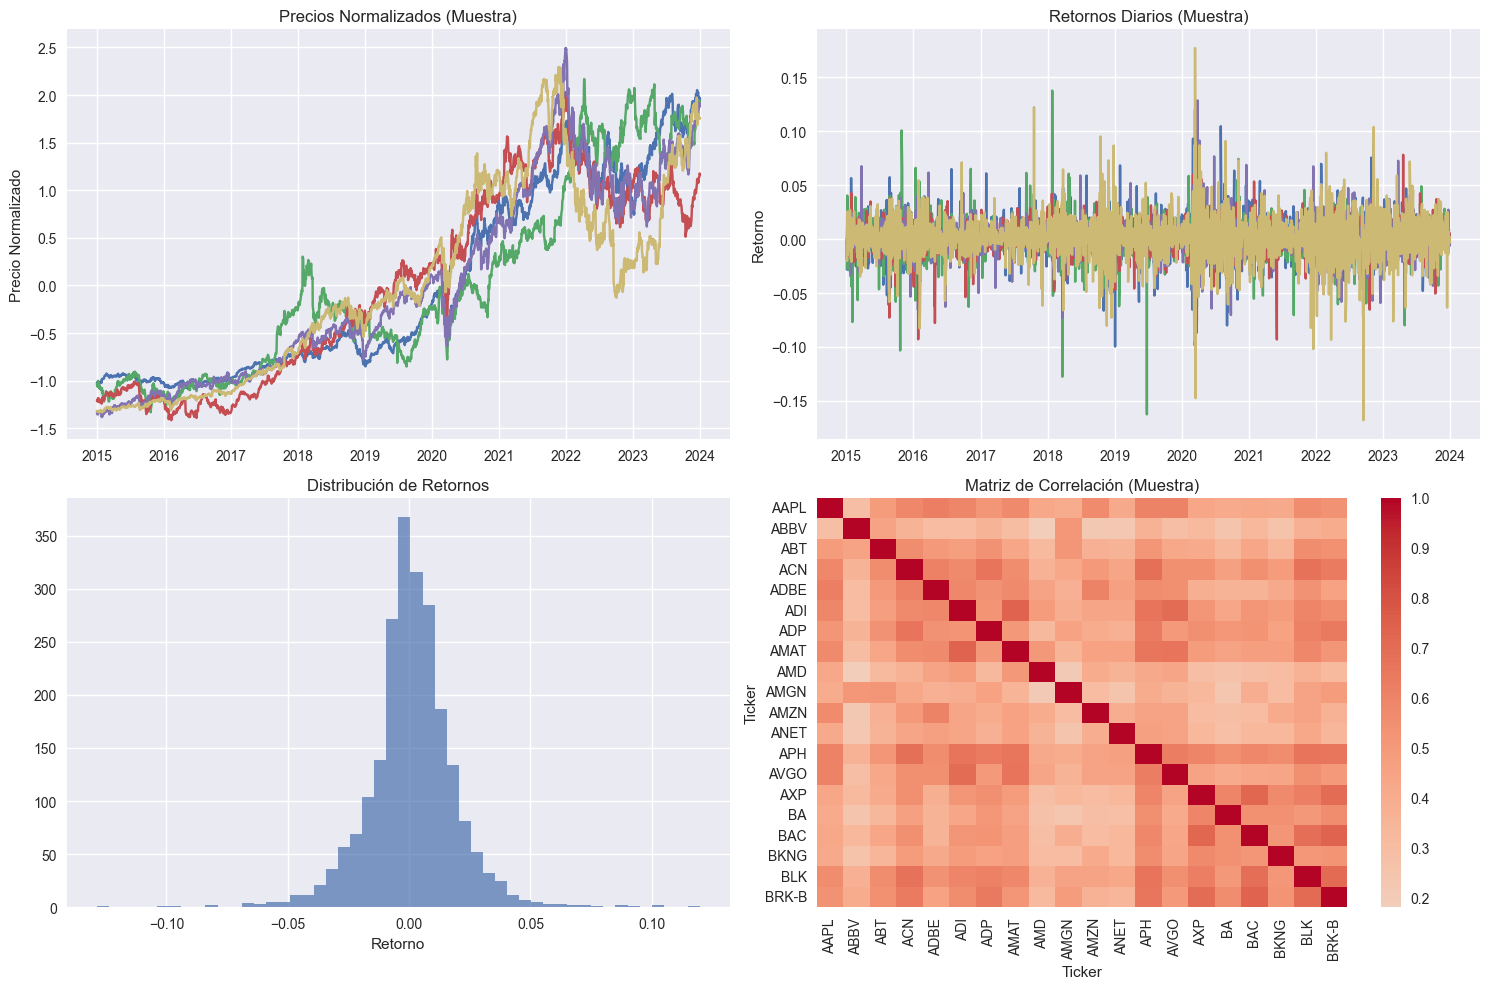

In [15]:
# =======================================================
# 🎯 PASO 1: DATASET TEMPORAL FORMALIZADO
# =======================================================

# Configuración temporal
START_DATE = '2015-01-01'
END_DATE = '2024-01-01'


print("🏗️ CONSTRUYENDO DATASET TEMPORAL FORMALIZADO")
print("=" * 50)

# Obtener S&P 500 tickers (usando el enfoque que ya conocemos)
def get_sp500_tickers():
    # URL de la lista del S&P 500
    url = "https://www.slickcharts.com/sp500"


    # Hacer la petición con headers para evitar bloqueos
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Raise exception for bad status codes

    # Parsear el HTML
    soup = BeautifulSoup(response.text, 'html.parser')

    # Encontrar la tabla
    table = soup.find('table')

    if table:
        # Leer la tabla con pandas
        df = pd.read_html(str(table))[0]
        
        # Extraer los tickers
        if 'Symbol' in df.columns:
            tickers = df['Symbol'].tolist()
            print(f"Found {len(tickers)} tickers")
            
        else:
            print("Available columns:", df.columns.tolist())

        
    else:
        print("No table found on the page")

    # En la lista de ticker, reemplazar los "." por "-"
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    
    return tickers[:120]

# Obtener tickers
tickers = get_sp500_tickers()

# Descargar datos históricos
print(f"📥 Descargando datos históricos ({START_DATE} a {END_DATE})...")
stock_data = yf.download(tickers, start=START_DATE, end=END_DATE, progress=False)

# Usar solo precios de cierre
if isinstance(stock_data.columns, pd.MultiIndex):
    close_prices = stock_data['Close']
else:
    close_prices = stock_data

# Limpiar datos
close_prices = close_prices.dropna(axis=1, thresh=len(close_prices)*0.8)  # Mantener acciones con >80% datos
close_prices = close_prices.fillna(method='ffill').fillna(method='bfill')

print(f"📊 Dataset final: {close_prices.shape[0]} días, {close_prices.shape[1]} acciones")
print(f"📅 Período: {close_prices.index[0].date()} a {close_prices.index[-1].date()}")

# Calcular retornos
returns = close_prices.pct_change().dropna()

# Normalizar precios (para embeddings)
normalized_prices = (close_prices - close_prices.mean()) / close_prices.std()

print("✅ Dataset temporal formalizado completado")

# Visualización rápida
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Precios normalizados (muestra)
axes[0,0].plot(normalized_prices.iloc[:, :5])
axes[0,0].set_title('Precios Normalizados (Muestra)')
axes[0,0].set_ylabel('Precio Normalizado')

# Retornos (muestra)
axes[0,1].plot(returns.iloc[:, :5])
axes[0,1].set_title('Retornos Diarios (Muestra)')
axes[0,1].set_ylabel('Retorno')

# Distribución de retornos
axes[1,0].hist(returns.iloc[:, 0], bins=50, alpha=0.7)
axes[1,0].set_title('Distribución de Retornos')
axes[1,0].set_xlabel('Retorno')

# Correlación entre acciones (muestra)
corr_sample = returns.iloc[:, :20].corr()
sns.heatmap(corr_sample, ax=axes[1,1], cmap='coolwarm', center=0)
axes[1,1].set_title('Matriz de Correlación (Muestra)')

plt.tight_layout()
plt.show()

🪟 CREANDO SLIDING WINDOWS
✅ 75 ventanas de retornos creadas
✅ 75 ventanas de precios creadas
📏 Cada ventana: 30 días × 110 acciones
\n🧮 GENERANDO EMBEDDINGS
📊 Procesando método: PCA
✅ 75 embeddings generados con pca
📊 Procesando método: SVD
✅ 75 embeddings generados con svd
\n📈 Embeddings principales: 75 ventanas
📏 Dimensión por embedding: (110, 10)


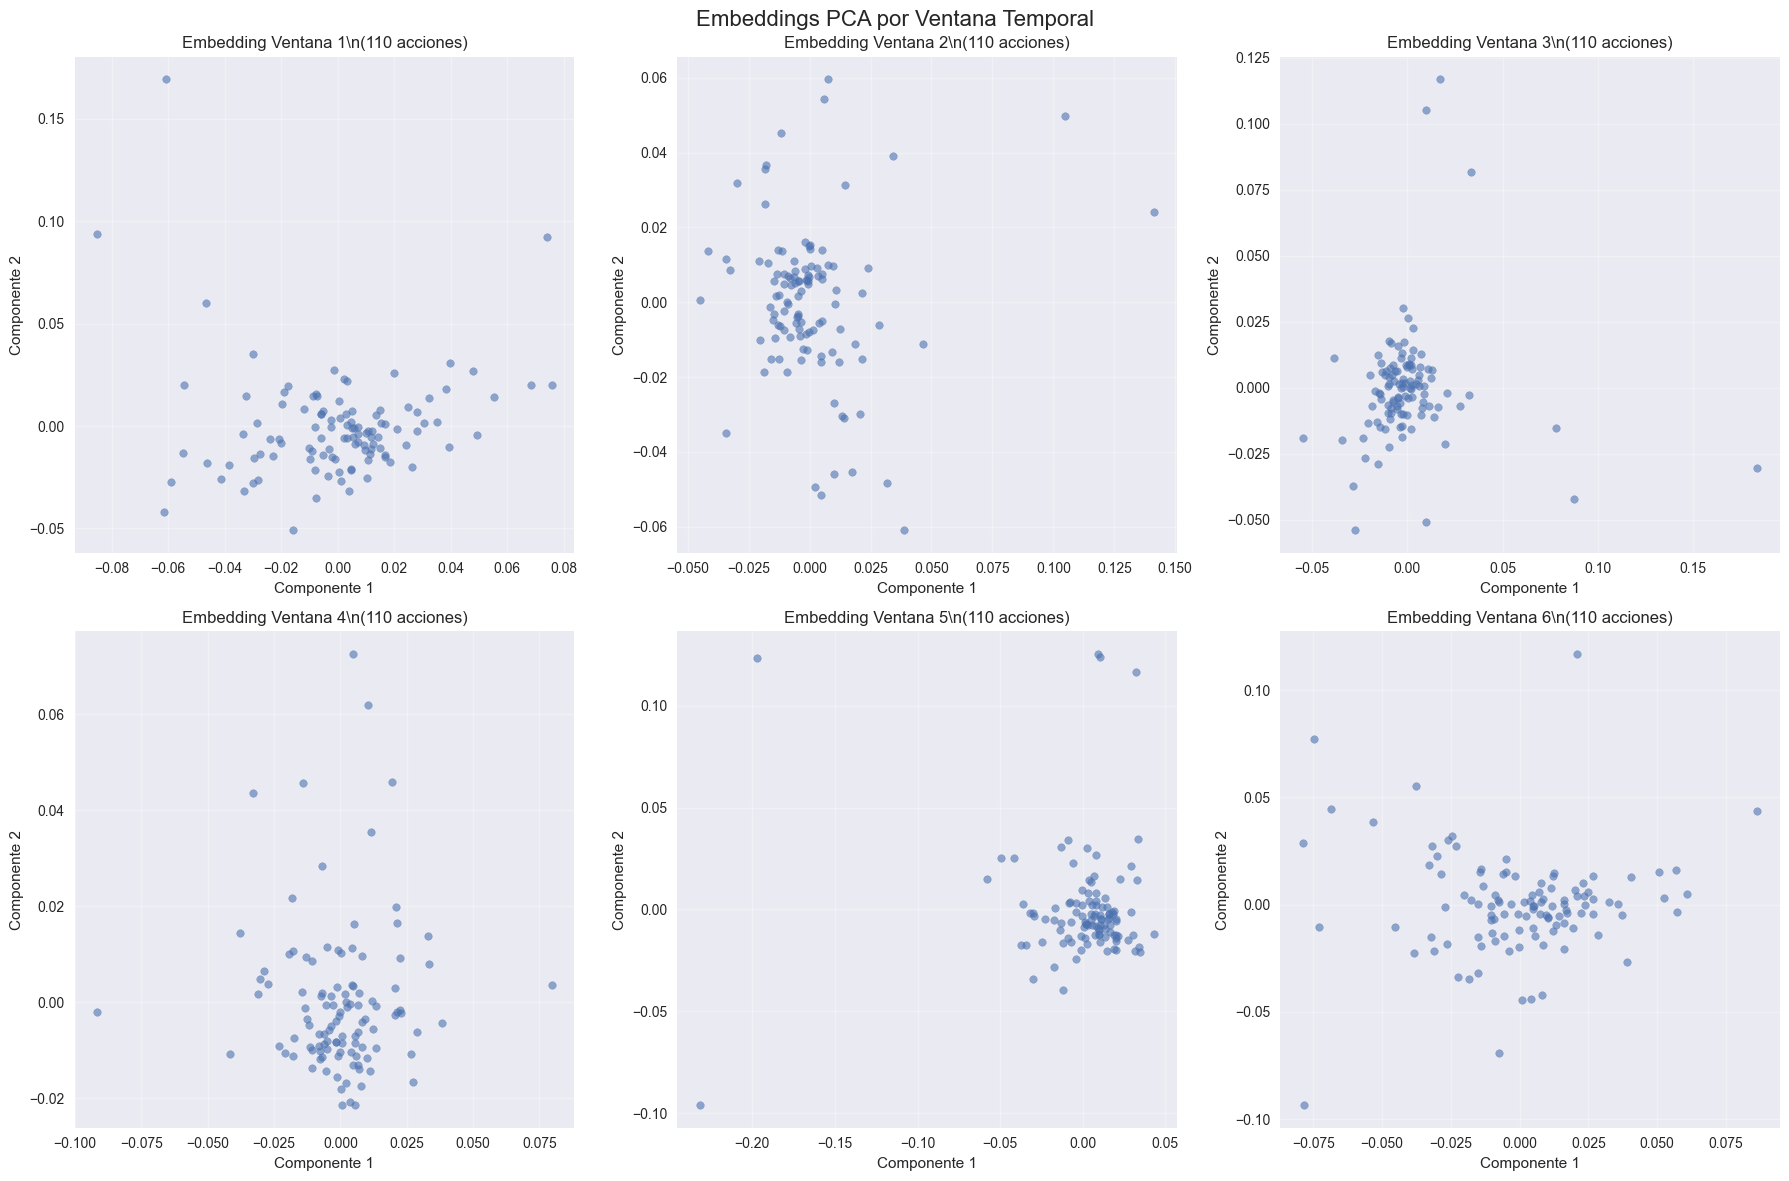

✅ Sliding windows y embeddings completados


In [16]:
# =======================================================
# 🪟 PASO 2: SLIDING WINDOWS Y EMBEDDINGS
# =======================================================

def create_sliding_windows(data, window_size=60, overlap=30):
    """
    Crea sliding windows de los datos temporales
    
    Args:
        data: DataFrame con datos temporales (tiempo × acciones)
        window_size: Tamaño de ventana en días
        overlap: Solapamiento entre ventanas
    
    Returns:
        list de DataFrames, cada uno una ventana temporal
    """
    windows = []
    step = window_size - overlap
    
    for i in range(0, len(data) - window_size + 1, step):
        window = data.iloc[i:i + window_size]
        if len(window) == window_size:  # Asegurar ventana completa
            windows.append(window)
    
    return windows

print("🪟 CREANDO SLIDING WINDOWS")
print("=" * 30)

# Crear windows de retornos y precios normalizados
return_windows = create_sliding_windows(returns, WINDOW_SIZE, OVERLAP)
price_windows = create_sliding_windows(normalized_prices, WINDOW_SIZE, OVERLAP)

print(f"✅ {len(return_windows)} ventanas de retornos creadas")
print(f"✅ {len(price_windows)} ventanas de precios creadas")
print(f"📏 Cada ventana: {WINDOW_SIZE} días × {returns.shape[1]} acciones")

# =======================================================
# 🧮 GENERACIÓN DE EMBEDDINGS POR VENTANA
# =======================================================

def generate_embeddings(windows, method='pca', n_components=10):
    """
    Genera embeddings para cada ventana temporal
    
    Args:
        windows: Lista de DataFrames (ventanas temporales)
        method: 'pca', 'tsne', 'svd'
        n_components: Dimensiones del embedding
    
    Returns:
        embeddings: Lista de arrays numpy con embeddings
        embedders: Lista de objetos entrenados para transformación
    """
    embeddings = []
    embedders = []
    
    for i, window in enumerate(windows):
        # Transponer: queremos (acciones × tiempo) para embedding
        window_T = window.T.values  # (n_stocks, window_size)
        
        if method == 'pca':
            embedder = PCA(n_components=n_components, random_state=42)
        elif method == 'tsne':
            embedder = TSNE(n_components=min(n_components, 3), random_state=42, perplexity=min(30, len(window_T)-1))
        elif method == 'svd':
            embedder = TruncatedSVD(n_components=n_components, random_state=42)
        else:
            raise ValueError(f"Método {method} no reconocido")
        
        # Fit y transform
        try:
            if method == 'tsne':
                # t-SNE no tiene fit/transform separado
                embedding = embedder.fit_transform(window_T)
            else:
                embedding = embedder.fit_transform(window_T)
            
            embeddings.append(embedding)
            embedders.append(embedder)
            
        except Exception as e:
            print(f"⚠️ Error en ventana {i}: {e}")
            continue
    
    return embeddings, embedders

print("\\n🧮 GENERANDO EMBEDDINGS")
print("=" * 25)

# Generar embeddings con diferentes métodos
embedding_methods = ['pca', 'svd']  # t-SNE muy lento para muchas ventanas
all_embeddings = {}

for method in embedding_methods:
    print(f"📊 Procesando método: {method.upper()}")
    embeddings, embedders = generate_embeddings(return_windows, method=method, n_components=10)
    all_embeddings[method] = {
        'embeddings': embeddings,
        'embedders': embedders
    }
    print(f"✅ {len(embeddings)} embeddings generados con {method}")

# Usar PCA como método principal
main_embeddings = all_embeddings['pca']['embeddings']
main_embedders = all_embeddings['pca']['embedders']

print(f"\\n📈 Embeddings principales: {len(main_embeddings)} ventanas")
if main_embeddings:
    print(f"📏 Dimensión por embedding: {main_embeddings[0].shape}")

# Visualización de embeddings
if len(main_embeddings) > 0:
    # Tomar algunos embeddings para visualizar
    sample_embeddings = main_embeddings[:min(6, len(main_embeddings))]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, embedding in enumerate(sample_embeddings):
        if i < 6:
            # Visualizar en 2D (primeras 2 componentes)
            axes[i].scatter(embedding[:, 0], embedding[:, 1], alpha=0.6, s=30)
            axes[i].set_title(f'Embedding Ventana {i+1}\\n({embedding.shape[0]} acciones)')
            axes[i].set_xlabel('Componente 1')
            axes[i].set_ylabel('Componente 2')
            axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Embeddings PCA por Ventana Temporal', fontsize=16)
    plt.tight_layout()
    plt.show()

print("✅ Sliding windows y embeddings completados")

🕸️ APLICANDO TDA A EMBEDDINGS
✅ 75 diagramas de persistencia calculados
📊 Características TDA extraídas: (75, 11)
🏷️ Columnas de características: ['window_idx', 'n_components_dim0', 'max_persistence_dim0', 'mean_persistence_dim0', 'std_persistence_dim0', 'persistence_entropy_dim0', 'n_components_dim1', 'max_persistence_dim1', 'mean_persistence_dim1', 'std_persistence_dim1', 'persistence_entropy_dim1']
\n📈 ESTADÍSTICAS DE CARACTERÍSTICAS TOPOLÓGICAS:
       window_idx  n_components_dim0  max_persistence_dim0  \
count   75.000000               75.0             75.000000   
mean    37.000000              109.0              7.583578   
std     21.794495                0.0              1.201373   
min      0.000000              109.0              4.319448   
25%     18.500000              109.0              6.856753   
50%     37.000000              109.0              7.480746   
75%     55.500000              109.0              8.535275   
max     74.000000              109.0             1

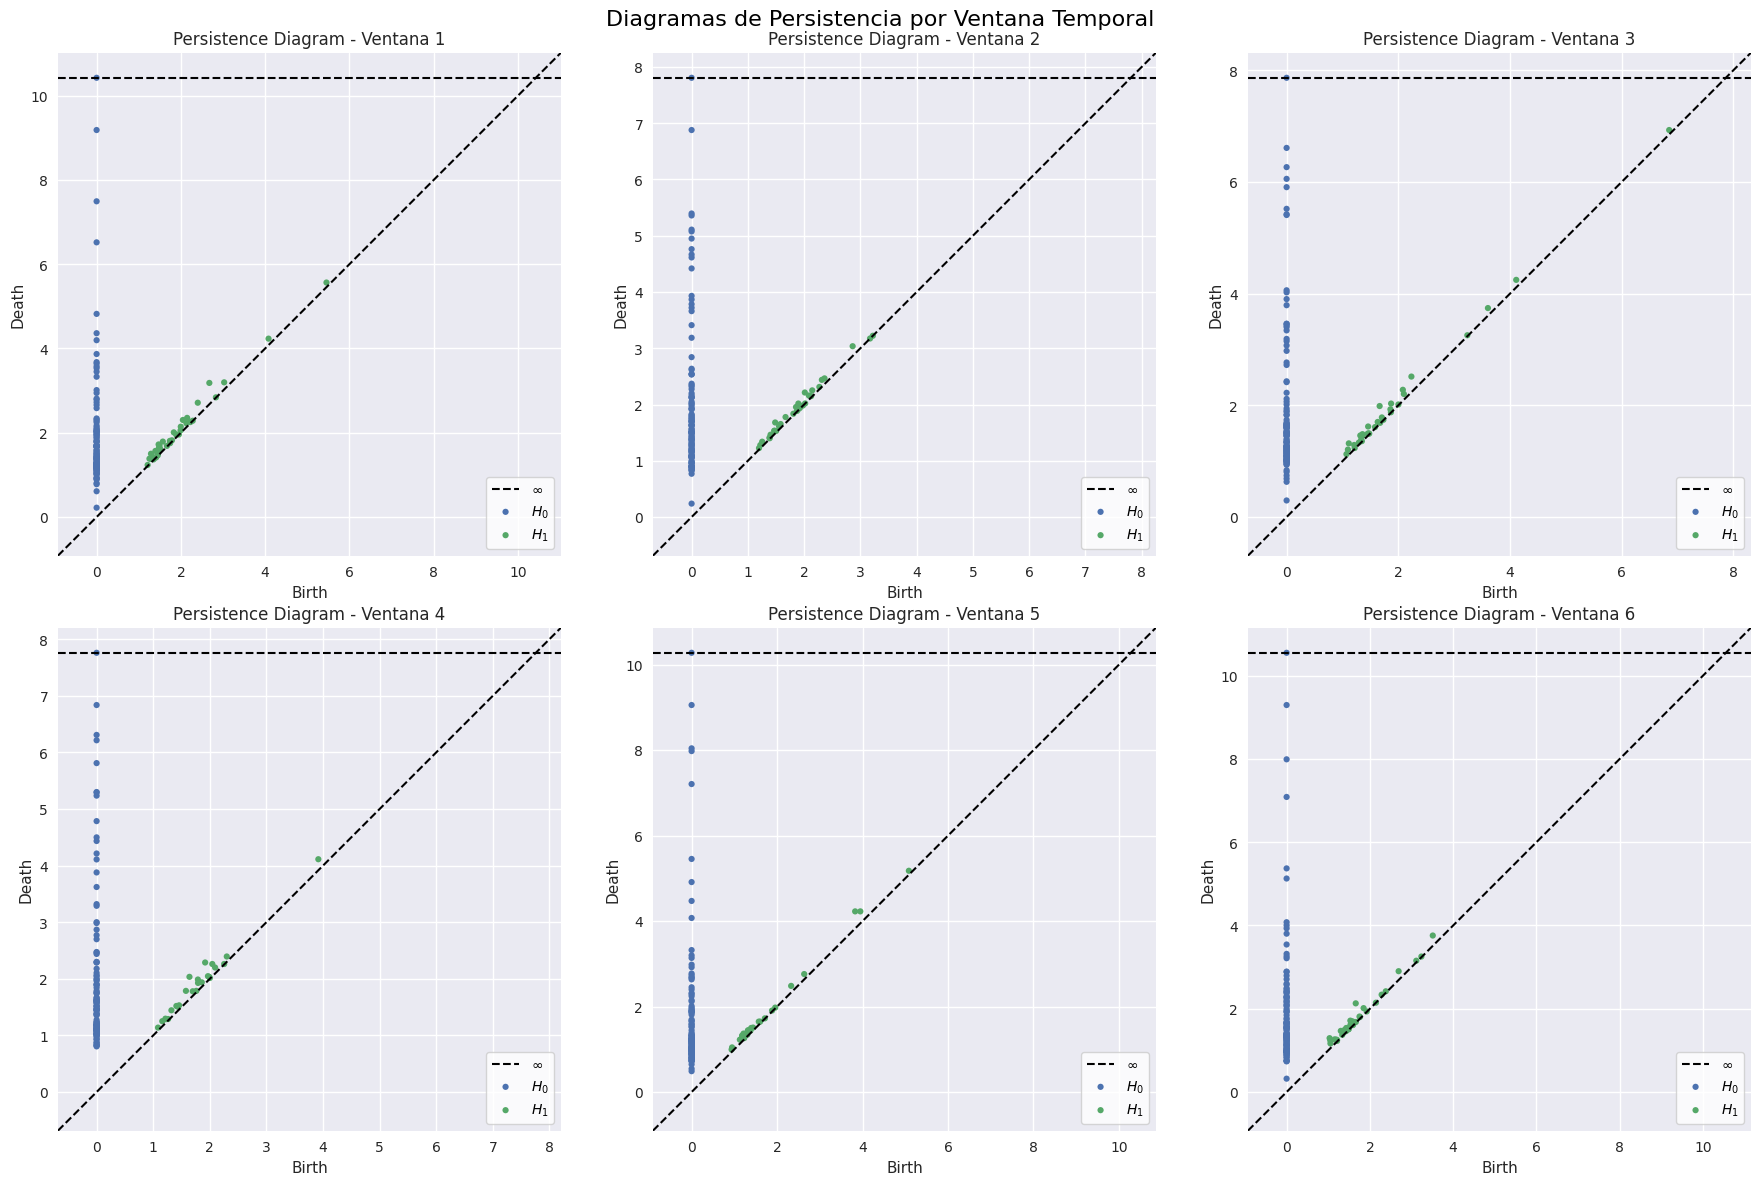

\n📊 CLUSTERING TOPOLÓGICO DE VENTANAS
✅ 5 clusters identificados
  Cluster 0: 19 ventanas (25.3%)
  Cluster 1: 15 ventanas (20.0%)
  Cluster 2: 23 ventanas (30.7%)
  Cluster 3: 5 ventanas (6.7%)
  Cluster 4: 13 ventanas (17.3%)


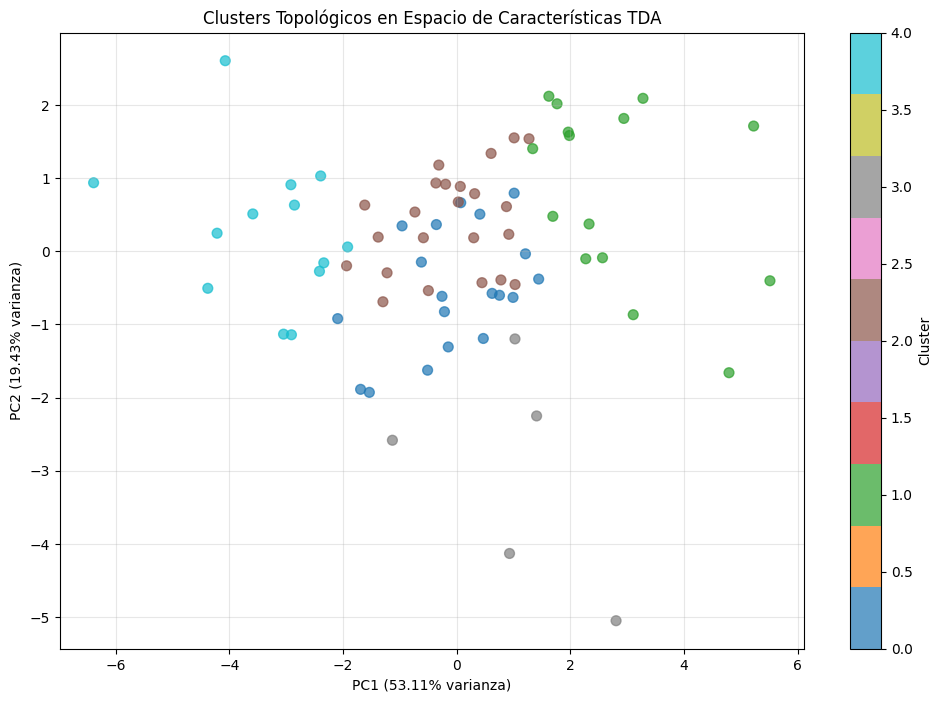

📊 Varianza explicada por PC1+PC2: 72.54%
✅ TDA aplicado exitosamente


In [17]:
# =======================================================
# 🕸️ PASO 3: TDA - ANÁLISIS TOPOLÓGICO DE EMBEDDINGS
# =======================================================

def compute_persistence_diagrams(embeddings, maxdim=1):
    """
    Calcula diagramas de persistencia para cada embedding
    
    Args:
        embeddings: Lista de arrays numpy con embeddings
        maxdim: Dimensión máxima de homología
    
    Returns:
        persistence_diagrams: Lista de diagramas de persistencia
        tda_features: DataFrame con características topológicas extraídas
    """
    persistence_diagrams = []
    tda_features_list = []
    
    for i, embedding in enumerate(embeddings):
        try:
            # Normalizar embedding
            scaler = StandardScaler()
            embedding_scaled = scaler.fit_transform(embedding)
            
            # Calcular diagrama de persistencia
            dgms = ripser(embedding_scaled, maxdim=maxdim)['dgms']
            persistence_diagrams.append(dgms)
            
            # Extraer características topológicas
            features = extract_topological_features(dgms, window_idx=i)
            tda_features_list.append(features)
            
        except Exception as e:
            print(f"⚠️ Error en embedding {i}: {e}")
            continue
    
    tda_features_df = pd.DataFrame(tda_features_list)
    return persistence_diagrams, tda_features_df

def extract_topological_features(dgms, window_idx):
    """Extrae características numéricas de diagramas de persistencia"""
    features = {'window_idx': window_idx}
    
    for dim, dgm in enumerate(dgms):
        # Filtrar puntos infinitos
        finite_dgm = dgm[np.isfinite(dgm).all(axis=1)]
        
        if len(finite_dgm) > 0:
            # Características básicas
            features[f'n_components_dim{dim}'] = len(finite_dgm)
            features[f'max_persistence_dim{dim}'] = np.max(finite_dgm[:, 1] - finite_dgm[:, 0])
            features[f'mean_persistence_dim{dim}'] = np.mean(finite_dgm[:, 1] - finite_dgm[:, 0])
            features[f'std_persistence_dim{dim}'] = np.std(finite_dgm[:, 1] - finite_dgm[:, 0])
            
            # Persistence entropy (medida de complejidad topológica)
            persistences = finite_dgm[:, 1] - finite_dgm[:, 0]
            if persistences.sum() > 0:
                normalized_pers = persistences / persistences.sum()
                entropy = -np.sum(normalized_pers * np.log(normalized_pers + 1e-10))
                features[f'persistence_entropy_dim{dim}'] = entropy
            else:
                features[f'persistence_entropy_dim{dim}'] = 0
        else:
            # Sin componentes
            features[f'n_components_dim{dim}'] = 0
            features[f'max_persistence_dim{dim}'] = 0
            features[f'mean_persistence_dim{dim}'] = 0
            features[f'std_persistence_dim{dim}'] = 0
            features[f'persistence_entropy_dim{dim}'] = 0
    
    return features

print("🕸️ APLICANDO TDA A EMBEDDINGS")
print("=" * 35)

# Calcular diagramas de persistencia
persistence_diagrams, tda_features = compute_persistence_diagrams(main_embeddings, maxdim=1)

print(f"✅ {len(persistence_diagrams)} diagramas de persistencia calculados")
print(f"📊 Características TDA extraídas: {tda_features.shape}")
print(f"🏷️ Columnas de características: {list(tda_features.columns)}")

# Mostrar estadísticas de características TDA
print("\\n📈 ESTADÍSTICAS DE CARACTERÍSTICAS TOPOLÓGICAS:")
print(tda_features.describe())

# Visualizar algunos diagramas de persistencia
if len(persistence_diagrams) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i in range(min(6, len(persistence_diagrams))):
        try:
            # Visualizar diagrama de persistencia
            plot_diagrams(persistence_diagrams[i], ax=axes[i], show=False)
            axes[i].set_title(f'Persistence Diagram - Ventana {i+1}')
        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error: {str(e)[:30]}...', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'Ventana {i+1} (Error)')
    
    plt.suptitle('Diagramas de Persistencia por Ventana Temporal', fontsize=16)
    plt.tight_layout()
    plt.show()

# =======================================================
# 📊 CLUSTERING TOPOLÓGICO DE ACCIONES
# =======================================================

def cluster_stocks_by_topology(embeddings, tda_features, n_clusters=5, method='kmeans'):
    """
    Agrupa acciones basándose en características topológicas
    
    Args:
        embeddings: Lista de embeddings
        tda_features: DataFrame con características TDA
        n_clusters: Número de clusters
        method: 'kmeans' o 'dbscan'
    
    Returns:
        cluster_labels: Etiquetas de cluster por ventana
        clusterer: Objeto clustering entrenado
    """
    # Usar características TDA para clustering
    feature_cols = [col for col in tda_features.columns if col != 'window_idx']
    X_tda = tda_features[feature_cols].fillna(0)
    
    # Normalizar características
    scaler = StandardScaler()
    X_tda_scaled = scaler.fit_transform(X_tda)
    
    if method == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    elif method == 'dbscan':
        clusterer = DBSCAN(eps=0.5, min_samples=3)
    
    cluster_labels = clusterer.fit_predict(X_tda_scaled)
    
    return cluster_labels, clusterer, X_tda_scaled

print("\\n📊 CLUSTERING TOPOLÓGICO DE VENTANAS")
print("=" * 40)

# Realizar clustering
cluster_labels, clusterer, X_tda_scaled = cluster_stocks_by_topology(
    main_embeddings, tda_features, n_clusters=5
)

# Análisis de clusters
unique_labels = np.unique(cluster_labels)
print(f"✅ {len(unique_labels)} clusters identificados")

for label in unique_labels:
    count = np.sum(cluster_labels == label)
    percentage = count / len(cluster_labels) * 100
    print(f"  Cluster {label}: {count} ventanas ({percentage:.1f}%)")

# Visualizar clusters en espacio TDA
if X_tda_scaled.shape[1] >= 2:
    # PCA para visualización
    pca_vis = PCA(n_components=2, random_state=42)
    X_vis = pca_vis.fit_transform(X_tda_scaled)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=cluster_labels, 
                         cmap='tab10', alpha=0.7, s=50)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel(f'PC1 ({pca_vis.explained_variance_ratio_[0]:.2%} varianza)')
    plt.ylabel(f'PC2 ({pca_vis.explained_variance_ratio_[1]:.2%} varianza)')
    plt.title('Clusters Topológicos en Espacio de Características TDA')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"📊 Varianza explicada por PC1+PC2: {pca_vis.explained_variance_ratio_.sum():.2%}")

print("✅ TDA aplicado exitosamente")

💥 DETECCIÓN DE RUPTURES EN SERIES TEMPORALES
📈 Índice de mercado analizado: 2264 días
💥 Puntos de cambio detectados: 67
📅 Fechas de cambios principales:
  1. 2015-02-09
  2. 2015-02-24
  3. 2015-08-14
  4. 2015-09-28
  5. 2015-11-02
  6. 2015-12-08
  7. 2016-02-22
  8. 2016-06-22
  9. 2016-07-14
  10. 2016-09-09
  11. 2016-09-30
  12. 2016-11-04
  13. 2018-01-02
  14. 2018-01-24
  15. 2018-03-22
  16. 2018-04-06
  17. 2018-10-03
  18. 2018-11-14
  19. 2019-01-08
  20. 2019-02-06
  21. 2019-05-03
  22. 2019-06-03
  23. 2019-07-30
  24. 2019-08-13
  25. 2019-09-04
  26. 2019-10-02
  27. 2019-10-16
  28. 2020-01-21
  29. 2020-02-19
  30. 2020-03-04
  31. 2020-04-01
  32. 2020-04-30
  33. 2020-06-19
  34. 2020-07-06
  35. 2020-08-03
  36. 2020-08-31
  37. 2020-11-24
  38. 2020-12-23
  39. 2021-01-08
  40. 2021-01-25
  41. 2021-02-08
  42. 2021-02-23
  43. 2021-03-09
  44. 2021-05-26
  45. 2021-09-13
  46. 2021-10-04
  47. 2021-11-08
  48. 2021-11-22
  49. 2021-12-07
  50. 2021-12-21
  51. 

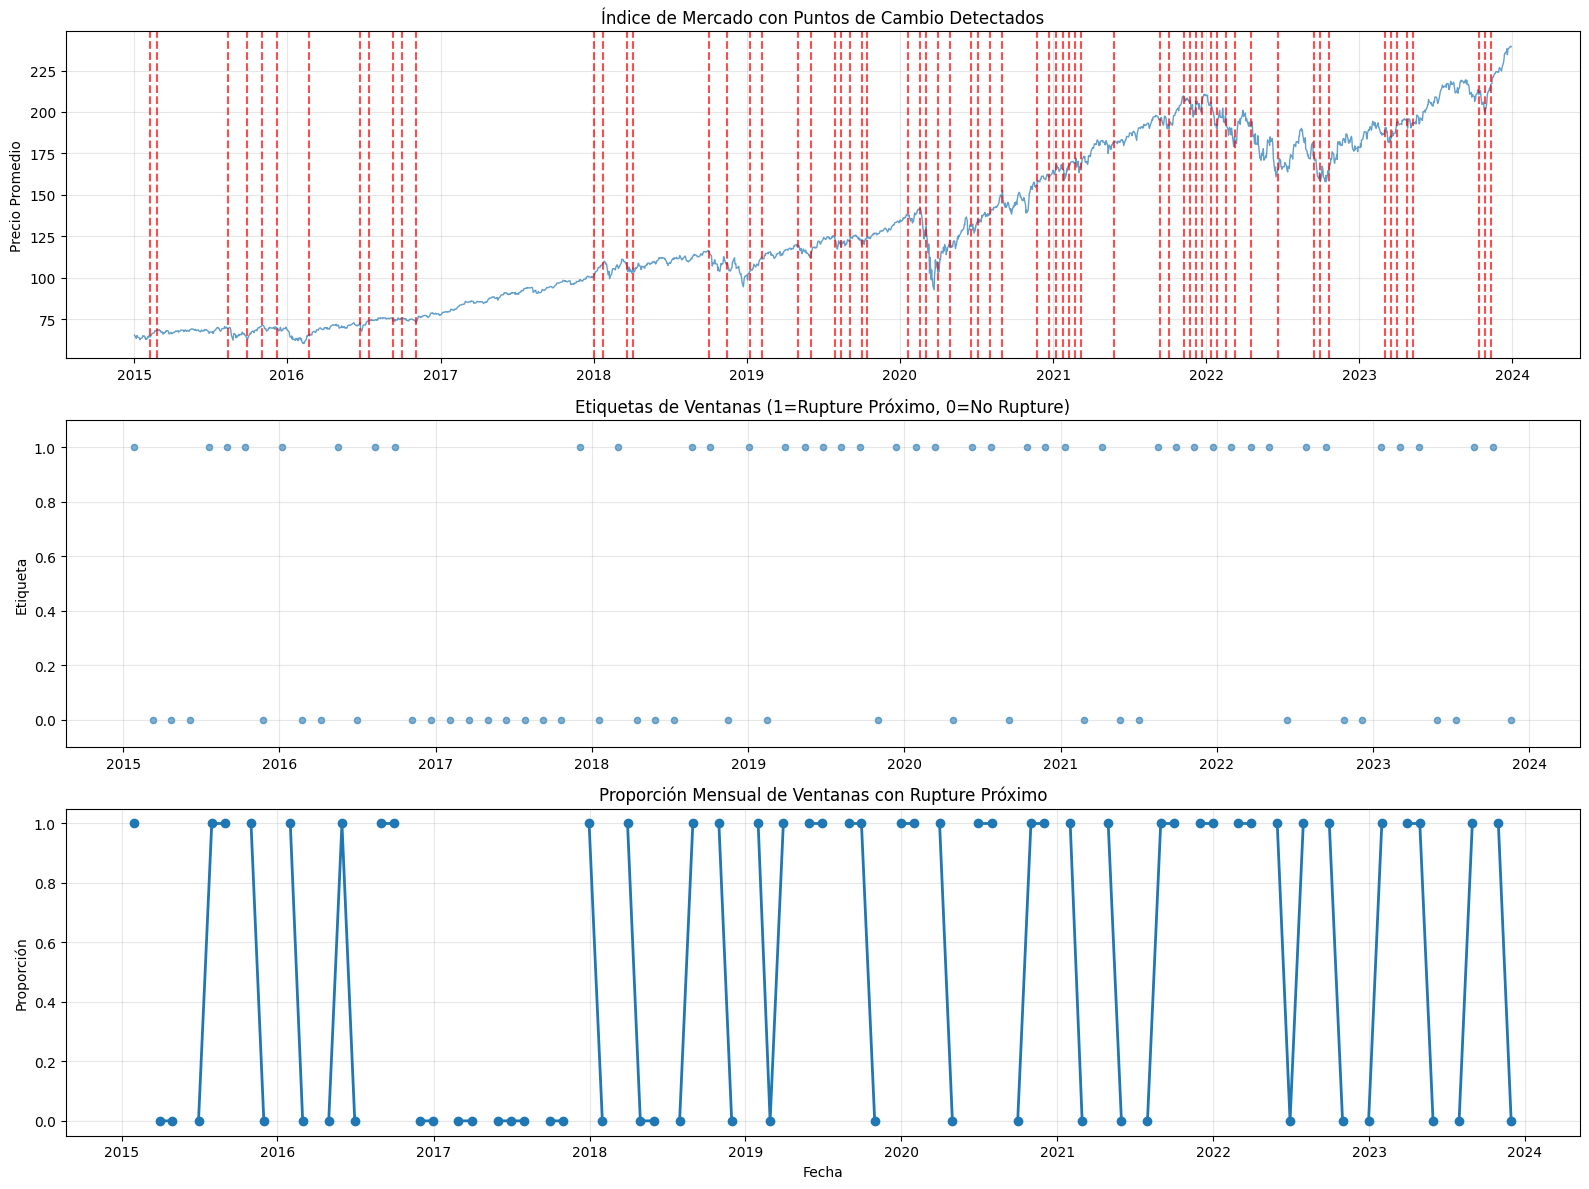

\n📊 ANÁLISIS POR PERÍODOS CRÍTICOS:
  COVID-19 2020: 50.0% ventanas con rupture próximo
  Inflación/Fed 2022: 62.5% ventanas con rupture próximo
✅ Detección de ruptures y etiquetado completado


In [18]:
# =======================================================
# 💥 PASO 4: DETECCIÓN DE RUPTURES Y ETIQUETADO
# =======================================================

def detect_changepoints(price_series, method='pelt', model='rbf', min_size=10):
    """
    Detecta puntos de cambio en series temporales usando ruptures
    
    Args:
        price_series: Serie temporal de precios
        method: 'pelt', 'binseg', 'window'
        model: 'l1', 'l2', 'rbf', 'normal'
        min_size: Tamaño mínimo de segmento
    
    Returns:
        changepoints: Lista de índices de cambio
        n_changes: Número de cambios detectados
    """
    # Usar retornos en lugar de precios para mejor detección
    returns_series = price_series.pct_change().dropna()
    
    # Configurar algoritmo
    if method == 'pelt':
        algo = rpt.Pelt(model=model, min_size=min_size)
    elif method == 'binseg':
        algo = rpt.Binseg(model=model, min_size=min_size)
    elif method == 'window':
        algo = rpt.Window(width=50, model=model, min_size=min_size)
    
    # Detectar cambios
    algo.fit(returns_series.values.reshape(-1, 1))
    changepoints = algo.predict(pen=1.0)  # penalty parameter
    
    # Remover el último punto (siempre es len(data))
    if changepoints[-1] == len(returns_series):
        changepoints = changepoints[:-1]
    
    return changepoints, len(changepoints)

print("💥 DETECCIÓN DE RUPTURES EN SERIES TEMPORALES")
print("=" * 50)

# Detectar cambios en el índice general (promedio del mercado)
market_index = close_prices.mean(axis=1)
market_changepoints, n_market_changes = detect_changepoints(market_index)

print(f"📈 Índice de mercado analizado: {len(market_index)} días")
print(f"💥 Puntos de cambio detectados: {n_market_changes}")

# Convertir índices a fechas
market_change_dates = [market_index.index[cp] for cp in market_changepoints]
print(f"📅 Fechas de cambios principales:")
for i, date in enumerate(market_change_dates):
    print(f"  {i+1}. {date.date()}")

# Detectar cambios en acciones individuales (muestra)
sample_stocks = list(close_prices.columns[:10])
stock_changepoints = {}

print(f"\\n🔍 Analizando cambios en acciones individuales (muestra)...")
for stock in sample_stocks:
    changepoints, n_changes = detect_changepoints(close_prices[stock])
    stock_changepoints[stock] = changepoints
    print(f"  {stock}: {n_changes} cambios detectados")

# =======================================================
# 🏷️ ETIQUETADO DE VENTANAS SEGÚN PROXIMIDAD A RUPTURES
# =======================================================

def label_windows_by_ruptures(return_windows, changepoints, prediction_horizon=30):
    """
    Etiqueta ventanas según si preceden a un rupture
    
    Args:
        return_windows: Lista de ventanas temporales
        changepoints: Lista de puntos de cambio
        prediction_horizon: Días hacia adelante para considerar 'próximo'
    
    Returns:
        labels: Lista de etiquetas binarias (1=rupture próximo, 0=no)
        window_dates: Lista de fechas centrales de cada ventana
    """
    labels = []
    window_dates = []
    
    for window in return_windows:
        # Fecha central de la ventana
        center_date = window.index[len(window)//2]
        window_dates.append(center_date)
        
        # Fecha final de la ventana
        end_date = window.index[-1]
        
        # Buscar si hay algún changepoint en el horizonte de predicción
        rupture_near = False
        for cp_idx in changepoints:
            cp_date = market_index.index[cp_idx]
            days_to_rupture = (cp_date - end_date).days
            
            if 0 <= days_to_rupture <= prediction_horizon:
                rupture_near = True
                break
        
        labels.append(1 if rupture_near else 0)
    
    return labels, window_dates

# Etiquetar ventanas
rupture_labels, window_dates = label_windows_by_ruptures(
    return_windows, market_changepoints, prediction_horizon=30
)

print(f"\\n🏷️ ETIQUETADO DE VENTANAS COMPLETADO")
print("=" * 40)
print(f"📊 Total de ventanas etiquetadas: {len(rupture_labels)}")
print(f"💥 Ventanas con rupture próximo: {sum(rupture_labels)} ({sum(rupture_labels)/len(rupture_labels)*100:.1f}%)")
print(f"✅ Ventanas sin rupture próximo: {len(rupture_labels)-sum(rupture_labels)} ({(len(rupture_labels)-sum(rupture_labels))/len(rupture_labels)*100:.1f}%)")

# Visualización de ruptures y etiquetado
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 1. Serie temporal con puntos de cambio
axes[0].plot(market_index.index, market_index.values, linewidth=1, alpha=0.7)
for cp_date in market_change_dates:
    axes[0].axvline(x=cp_date, color='red', linestyle='--', alpha=0.7)
axes[0].set_title('Índice de Mercado con Puntos de Cambio Detectados')
axes[0].set_ylabel('Precio Promedio')
axes[0].grid(True, alpha=0.3)

# 2. Distribución temporal de etiquetas
window_dates_series = pd.Series(rupture_labels, index=window_dates)
axes[1].scatter(window_dates, rupture_labels, alpha=0.6, s=20)
axes[1].set_title('Etiquetas de Ventanas (1=Rupture Próximo, 0=No Rupture)')
axes[1].set_ylabel('Etiqueta')
axes[1].set_ylim(-0.1, 1.1)
axes[1].grid(True, alpha=0.3)

# 3. Análisis temporal de ruptures
monthly_ruptures = pd.Series(rupture_labels, index=window_dates).resample('M').mean()
axes[2].plot(monthly_ruptures.index, monthly_ruptures.values, marker='o', linewidth=2)
axes[2].set_title('Proporción Mensual de Ventanas con Rupture Próximo')
axes[2].set_ylabel('Proporción')
axes[2].set_xlabel('Fecha')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis por períodos críticos
print(f"\\n📊 ANÁLISIS POR PERÍODOS CRÍTICOS:")
critical_periods = [
    ('2008-09-01', '2009-03-01', 'Crisis Financiera 2008'),
    ('2020-02-01', '2020-05-01', 'COVID-19 2020'),
    ('2022-01-01', '2022-12-31', 'Inflación/Fed 2022')
]

for start, end, name in critical_periods:
    period_mask = (pd.Series(window_dates) >= start) & (pd.Series(window_dates) <= end)
    if period_mask.any():
        period_labels = np.array(rupture_labels)[period_mask]
        rupture_rate = period_labels.mean()
        print(f"  {name}: {rupture_rate:.1%} ventanas con rupture próximo")

print("✅ Detección de ruptures y etiquetado completado")

🤖 ENTRENAMIENTO DE MODELOS PREDICTIVOS
📊 Dataset predictivo creado:
   Features: 14 características
   Muestras: 75 ventanas
   Distribución target: [34 41] (No-Rupture: 34, Rupture: 41)
\n📅 División temporal:
   Entrenamiento: 52 muestras
   Test: 23 muestras
\n🌲 Entrenando Random Forest para predicción de ruptures...
\n📊 RESULTADOS RANDOM FOREST:
   Accuracy: 0.609
   AUC: 0.525
\n📋 Classification Report:
              precision    recall  f1-score   support

  No-Rupture       0.44      0.50      0.47         8
     Rupture       0.71      0.67      0.69        15

    accuracy                           0.61        23
   macro avg       0.58      0.58      0.58        23
weighted avg       0.62      0.61      0.61        23

\n🎯 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:
    1. max_persistence_dim1     : 0.1334
    2. persistence_entropy_dim1 : 0.1271
    3. mean_persistence_dim0    : 0.1111
    4. persistence_entropy_dim0 : 0.0918
    5. std_persistence_dim0     : 0.0891
    6. mean_p

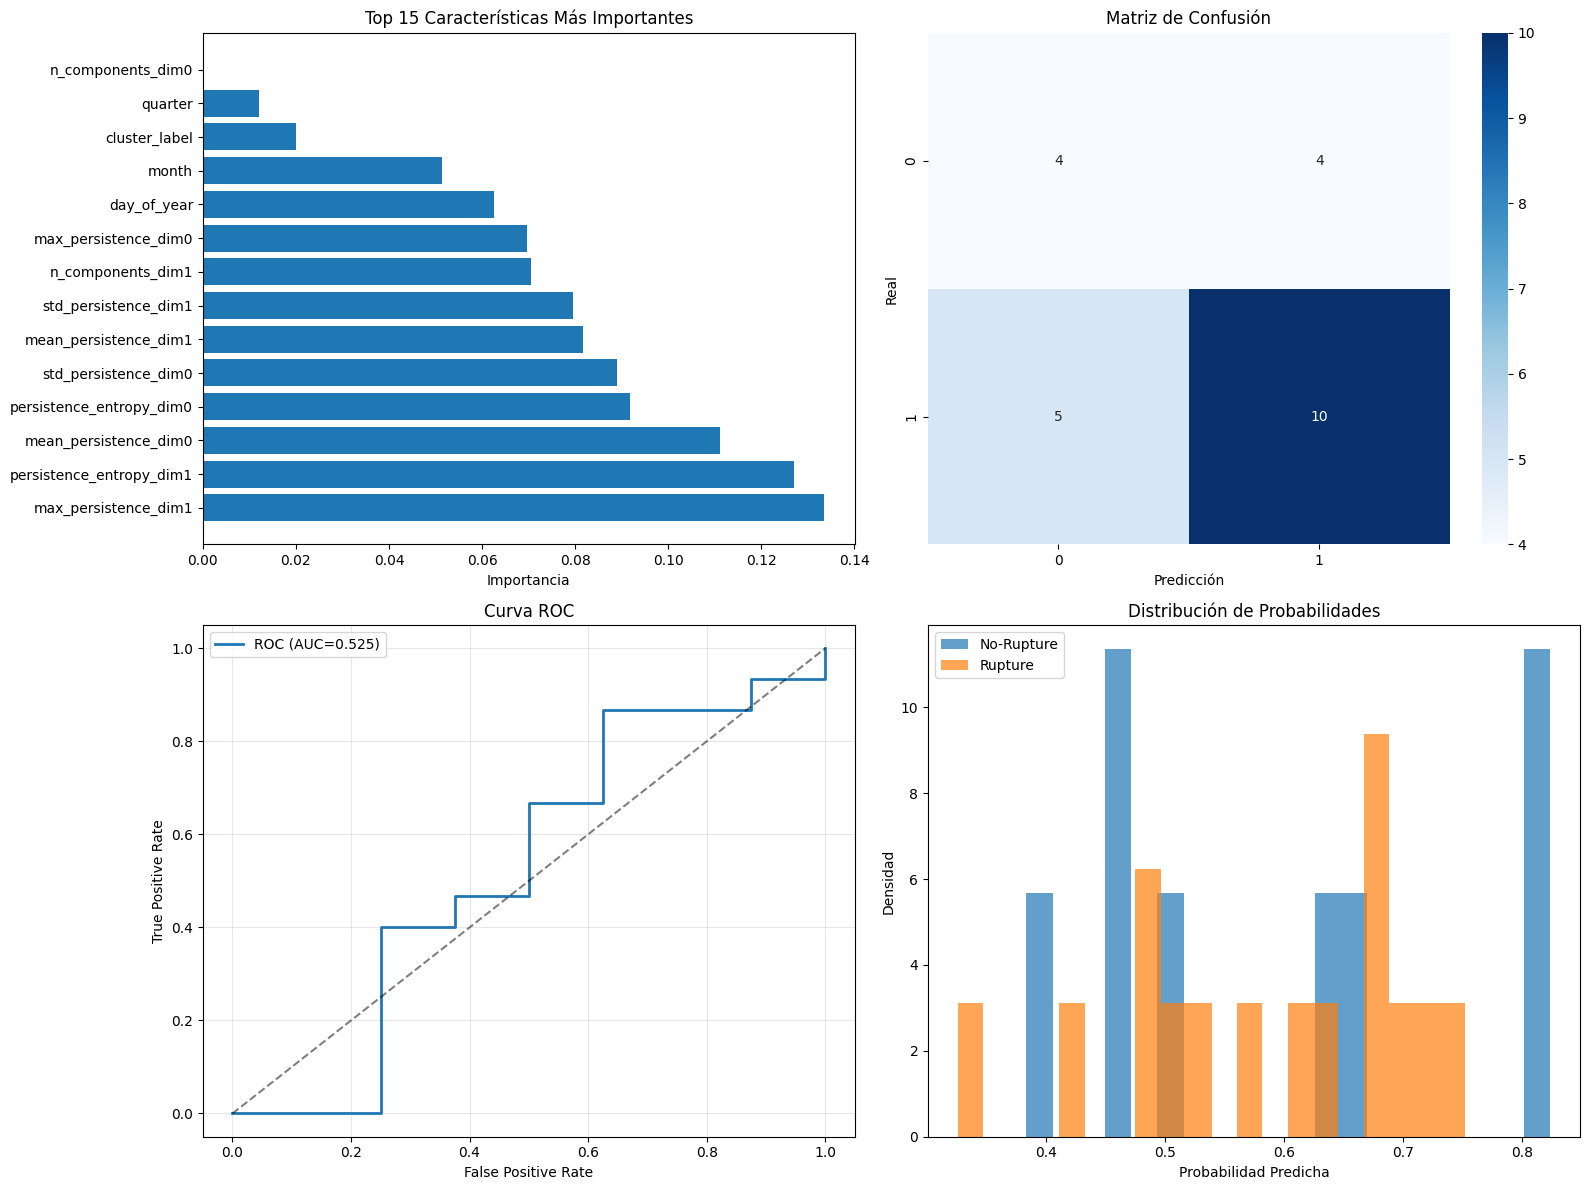

\n🔮 ANÁLISIS TEMPORAL DE PREDICCIONES:
📅 Performance anual:
      total_windows  true_ruptures  pred_ruptures  avg_proba  precision
date                                                                   
2021              7              5              3      0.529      0.714
2022              8              5              8      0.671      0.625
2023              8              5              3      0.552      0.500


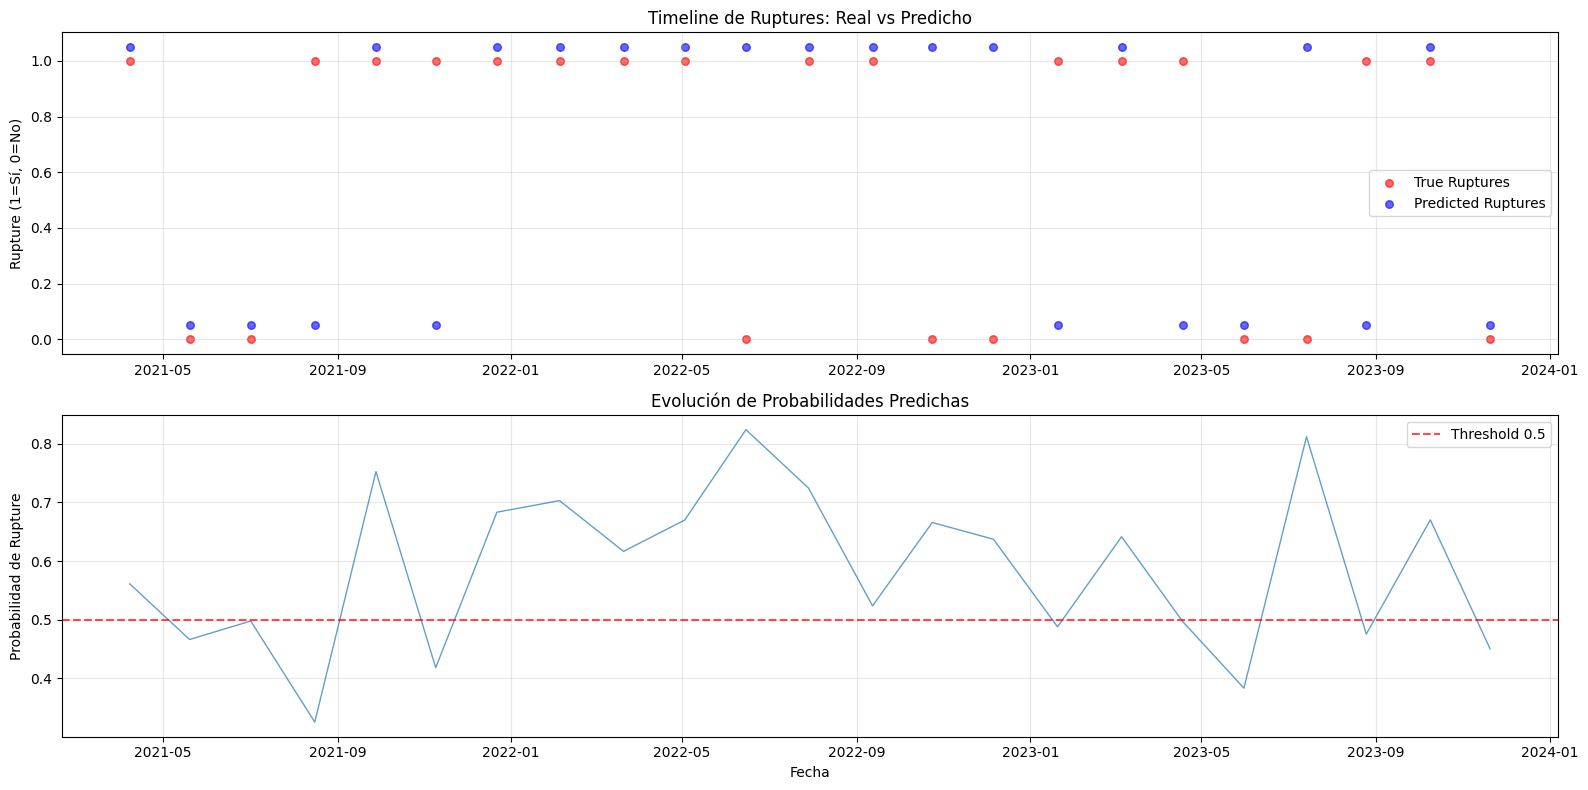

✅ Modelos predictivos entrenados y evaluados


In [19]:
# =======================================================
# 🤖 PASO 5: MODELOS PREDICTIVOS TOPOLÓGICOS
# =======================================================

def create_predictive_dataset(tda_features, cluster_labels, rupture_labels, window_dates):
    """
    Crea dataset para modelos predictivos combinando características TDA y clusters
    """
    # Combinar todas las características
    feature_cols = [col for col in tda_features.columns if col != 'window_idx']
    X_features = tda_features[feature_cols].fillna(0)
    
    # Añadir cluster como característica
    X_features['cluster_label'] = cluster_labels
    
    # Añadir características temporales
    dates_df = pd.DataFrame({'date': window_dates})
    dates_df['month'] = dates_df['date'].dt.month
    dates_df['quarter'] = dates_df['date'].dt.quarter
    dates_df['year'] = dates_df['date'].dt.year
    dates_df['day_of_year'] = dates_df['date'].dt.dayofyear
    
    # Combinar características
    X_combined = pd.concat([X_features.reset_index(drop=True), 
                           dates_df[['month', 'quarter', 'day_of_year']].reset_index(drop=True)], 
                          axis=1)
    
    return X_combined, np.array(rupture_labels)

print("🤖 ENTRENAMIENTO DE MODELOS PREDICTIVOS")
print("=" * 45)

# Crear dataset para predicción
X_pred, y_pred = create_predictive_dataset(tda_features, cluster_labels, rupture_labels, window_dates)

print(f"📊 Dataset predictivo creado:")
print(f"   Features: {X_pred.shape[1]} características")
print(f"   Muestras: {X_pred.shape[0]} ventanas")
print(f"   Distribución target: {np.bincount(y_pred)} (No-Rupture: {np.bincount(y_pred)[0]}, Rupture: {np.bincount(y_pred)[1]})")

# División temporal para validación (importante en series temporales)
split_idx = int(len(X_pred) * 0.7)  # 70% entrenamiento, 30% test

X_train = X_pred.iloc[:split_idx]
X_test = X_pred.iloc[split_idx:]
y_train = y_pred[:split_idx]
y_test = y_pred[split_idx:]

print(f"\\n📅 División temporal:")
print(f"   Entrenamiento: {len(X_train)} muestras")
print(f"   Test: {len(X_test)} muestras")

# =======================================================
# 🌲 RANDOM FOREST PARA PREDICCIÓN DE RUPTURES
# =======================================================

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Entrenar Random Forest
rf_rupture = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    class_weight='balanced',  # Importante para clases desbalanceadas
    random_state=42,
    n_jobs=-1
)

print("\\n🌲 Entrenando Random Forest para predicción de ruptures...")
rf_rupture.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_rupture.predict(X_test)
y_proba_rf = rf_rupture.predict_proba(X_test)[:, 1]

# Métricas
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"\\n📊 RESULTADOS RANDOM FOREST:")
print(f"   Accuracy: {accuracy_rf:.3f}")
print(f"   AUC: {auc_rf:.3f}")
print("\\n📋 Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No-Rupture', 'Rupture']))

# Importancia de características
feature_importance = pd.DataFrame({
    'feature': X_pred.columns,
    'importance': rf_rupture.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\\n🎯 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"   {i+1:2d}. {row['feature']:25s}: {row['importance']:.4f}")

# =======================================================
# 📈 VISUALIZACIONES DE RESULTADOS
# =======================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Importancia de características
top_features = feature_importance.head(15)
axes[0,0].barh(range(len(top_features)), top_features['importance'])
axes[0,0].set_yticks(range(len(top_features)))
axes[0,0].set_yticklabels(top_features['feature'])
axes[0,0].set_title('Top 15 Características Más Importantes')
axes[0,0].set_xlabel('Importancia')

# 2. Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Matriz de Confusión')
axes[0,1].set_xlabel('Predicción')
axes[0,1].set_ylabel('Real')

# 3. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
axes[1,0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={auc_rf:.3f})')
axes[1,0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('Curva ROC')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Distribución de probabilidades
axes[1,1].hist(y_proba_rf[y_test==0], bins=20, alpha=0.7, label='No-Rupture', density=True)
axes[1,1].hist(y_proba_rf[y_test==1], bins=20, alpha=0.7, label='Rupture', density=True)
axes[1,1].set_xlabel('Probabilidad Predicha')
axes[1,1].set_ylabel('Densidad')
axes[1,1].set_title('Distribución de Probabilidades')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# =======================================================
# 🔮 ANÁLISIS TEMPORAL DE PREDICCIONES
# =======================================================

# Crear serie temporal de predicciones
test_dates = window_dates[split_idx:]
predictions_ts = pd.DataFrame({
    'date': test_dates,
    'true_label': y_test,
    'pred_label': y_pred_rf,
    'pred_proba': y_proba_rf
})

print(f"\\n🔮 ANÁLISIS TEMPORAL DE PREDICCIONES:")
print("=" * 40)

# Análisis por año
yearly_performance = predictions_ts.groupby(predictions_ts['date'].dt.year).agg({
    'true_label': ['count', 'sum'],
    'pred_label': 'sum',
    'pred_proba': 'mean'
}).round(3)

yearly_performance.columns = ['total_windows', 'true_ruptures', 'pred_ruptures', 'avg_proba']
yearly_performance['precision'] = yearly_performance.apply(
    lambda row: accuracy_score(
        predictions_ts[predictions_ts['date'].dt.year == row.name]['true_label'],
        predictions_ts[predictions_ts['date'].dt.year == row.name]['pred_label']
    ), axis=1
).round(3)

print("📅 Performance anual:")
print(yearly_performance)

# Visualización temporal
plt.figure(figsize=(16, 8))

# Timeline de predicciones
plt.subplot(2, 1, 1)
plt.scatter(predictions_ts['date'], predictions_ts['true_label'], 
           alpha=0.6, s=30, label='True Ruptures', color='red')
plt.scatter(predictions_ts['date'], predictions_ts['pred_label'] + 0.05, 
           alpha=0.6, s=30, label='Predicted Ruptures', color='blue')
plt.ylabel('Rupture (1=Sí, 0=No)')
plt.title('Timeline de Ruptures: Real vs Predicho')
plt.legend()
plt.grid(True, alpha=0.3)

# Probabilidades a lo largo del tiempo
plt.subplot(2, 1, 2)
plt.plot(predictions_ts['date'], predictions_ts['pred_proba'], alpha=0.7, linewidth=1)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Threshold 0.5')
plt.ylabel('Probabilidad de Rupture')
plt.xlabel('Fecha')
plt.title('Evolución de Probabilidades Predichas')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Modelos predictivos entrenados y evaluados")

In [20]:
# =======================================================
# 💎 PASO 6: CREACIÓN DE ÍNDICES TOPOLÓGICOS
# =======================================================

class TopologicalIndexBuilder:
    """
    Construye índices basados en similaridad topológica
    """
    
    def __init__(self, embeddings, tda_features, stock_names, cluster_labels):
        self.embeddings = embeddings
        self.tda_features = tda_features
        self.stock_names = stock_names
        self.cluster_labels = cluster_labels
        
    def compute_topological_similarity(self, window_idx):
        """Calcula matriz de similaridad topológica para una ventana"""
        if window_idx >= len(self.embeddings):
            return None
            
        embedding = self.embeddings[window_idx]
        n_stocks = len(embedding)
        
        # Matriz de similaridad basada en distancia en embedding
        similarity_matrix = np.zeros((n_stocks, n_stocks))
        
        for i in range(n_stocks):
            for j in range(n_stocks):
                # Distancia euclidiana en espacio de embedding
                dist = np.linalg.norm(embedding[i] - embedding[j])
                # Convertir a similaridad (más cercano = más similar)
                similarity_matrix[i, j] = 1 / (1 + dist)
        
        return similarity_matrix
    
    def create_topological_index(self, window_idx, selection_method='top_similar', n_stocks=20):
        """
        Crea un índice topológico para una ventana específica
        
        Args:
            window_idx: Índice de ventana temporal
            selection_method: 'top_similar', 'cluster_based', 'persistence_weighted'
            n_stocks: Número de acciones a incluir
        
        Returns:
            selected_stocks: Lista de acciones seleccionadas
            weights: Pesos de cada acción
        """
        similarity_matrix = self.compute_topological_similarity(window_idx)
        if similarity_matrix is None:
            return [], []
        
        if selection_method == 'top_similar':
            # Seleccionar acciones más similares al centroide topológico
            centroid_similarity = similarity_matrix.mean(axis=1)
            top_indices = np.argsort(centroid_similarity)[-n_stocks:]
            
            # Pesos proporcionales a similaridad
            weights = centroid_similarity[top_indices]
            weights = weights / weights.sum()  # Normalizar
            
        elif selection_method == 'cluster_based':
            # Seleccionar acciones del cluster más coherente
            cluster_id = self.cluster_labels[window_idx]
            # Para simplicidad, usar top_similar como fallback
            centroid_similarity = similarity_matrix.mean(axis=1)
            top_indices = np.argsort(centroid_similarity)[-n_stocks:]
            weights = centroid_similarity[top_indices]
            weights = weights / weights.sum()
            
        elif selection_method == 'persistence_weighted':
            # Pesos basados en características de persistencia
            window_features = self.tda_features.iloc[window_idx]
            persistence_weight = window_features.get('max_persistence_dim1', 1.0)
            
            centroid_similarity = similarity_matrix.mean(axis=1)
            top_indices = np.argsort(centroid_similarity)[-n_stocks:]
            
            # Ajustar pesos por persistencia topológica
            weights = centroid_similarity[top_indices] * persistence_weight
            weights = weights / weights.sum()
        
        selected_stocks = [self.stock_names[i] for i in top_indices]
        
        return selected_stocks, weights

print("💎 CONSTRUCCIÓN DE ÍNDICES TOPOLÓGICOS")
print("=" * 45)

# Crear constructor de índices
index_builder = TopologicalIndexBuilder(
    main_embeddings, tda_features, list(close_prices.columns), cluster_labels
)

# =======================================================
# 📊 CONSTRUCCIÓN DE MÚLTIPLES ÍNDICES TOPOLÓGICOS
# =======================================================

def build_topological_indices(builder, return_windows, window_dates, methods=['top_similar']):
    """
    Construye múltiples índices topológicos a lo largo del tiempo
    """
    indices_data = {method: {'compositions': [], 'returns': [], 'dates': []} 
                   for method in methods}
    
    for window_idx, (window, date) in enumerate(zip(return_windows, window_dates)):
        if window_idx >= len(builder.embeddings):
            continue
            
        for method in methods:
            try:
                # Crear índice para esta ventana
                selected_stocks, weights = builder.create_topological_index(
                    window_idx, selection_method=method, n_stocks=20
                )
                
                if len(selected_stocks) > 0:
                    # Calcular retorno del índice en el siguiente período
                    # (usando ventana siguiente si existe)
                    if window_idx + 1 < len(return_windows):
                        next_window = return_windows[window_idx + 1]
                        
                        # Filtrar acciones disponibles en la ventana siguiente
                        available_stocks = [s for s in selected_stocks if s in next_window.columns]
                        if len(available_stocks) > 0:
                            # Renormalizar pesos para acciones disponibles
                            stock_indices = [selected_stocks.index(s) for s in available_stocks]
                            available_weights = np.array([weights[i] for i in stock_indices])
                            available_weights = available_weights / available_weights.sum()
                            
                            # Calcular retorno ponderado del índice
                            stock_returns = next_window[available_stocks].mean().values
                            index_return = np.sum(stock_returns * available_weights)
                            
                            # Guardar datos
                            indices_data[method]['compositions'].append(list(zip(available_stocks, available_weights)))
                            indices_data[method]['returns'].append(index_return)
                            indices_data[method]['dates'].append(date)
                
            except Exception as e:
                print(f"⚠️ Error en ventana {window_idx}, método {method}: {e}")
                continue
    
    return indices_data

# Construir índices con diferentes métodos
methods = ['top_similar', 'persistence_weighted']
print(f"🔨 Construyendo índices con métodos: {methods}")

topological_indices = build_topological_indices(
    index_builder, return_windows, window_dates, methods
)

# Mostrar estadísticas de construcción
for method, data in topological_indices.items():
    n_periods = len(data['returns'])
    avg_return = np.mean(data['returns']) if data['returns'] else 0
    print(f"📊 Método '{method}': {n_periods} períodos, retorno promedio: {avg_return:.4f}")

# =======================================================
# 📈 COMPARACIÓN CON S&P 500 Y ÍNDICE ALEATORIO
# =======================================================

def create_benchmark_indices(return_windows, window_dates):
    #Crea índices de referencia para comparación
    benchmarks = {'sp500': {'returns': [], 'dates': []},
                 'random': {'returns': [], 'dates': []}}
    
    for window_idx, (window, date) in enumerate(zip(return_windows, window_dates)):
        if window_idx + 1 < len(return_windows):
            next_window = return_windows[window_idx + 1]
            
            # S&P 500 (promedio ponderado por igual)
            sp500_return = next_window.mean().mean()  # Promedio de todas las acciones
            benchmarks['sp500']['returns'].append(sp500_return)
            benchmarks['sp500']['dates'].append(date)
            
            # Índice aleatorio (selección aleatoria de 20 acciones)
            np.random.seed(window_idx)  # Para reproducibilidad
            random_stocks = np.random.choice(next_window.columns, 
                                           size=min(20, len(next_window.columns)), 
                                           replace=False)
            random_return = next_window[random_stocks].mean().mean()
            benchmarks['random']['returns'].append(random_return)
            benchmarks['random']['dates'].append(date)
    
    return benchmarks

print(f"\n📊 CREANDO ÍNDICES DE REFERENCIA")
benchmarks = create_benchmark_indices(return_windows, window_dates)

# Combinar todos los índices para análisis
all_indices = {**topological_indices, **benchmarks}

# Calcular métricas de performance
performance_metrics = {}

for name, data in all_indices.items():
    if data['returns']:
        returns_array = np.array(data['returns'])
        
        metrics = {
            'total_return': np.sum(returns_array),
            'avg_return': np.mean(returns_array),
            'volatility': np.std(returns_array),
            'sharpe_ratio': np.mean(returns_array) / (np.std(returns_array) + 1e-10),
            'max_drawdown': np.min(np.cumsum(returns_array) - np.maximum.accumulate(np.cumsum(returns_array))),
            'n_periods': len(returns_array)
        }
        
        performance_metrics[name] = metrics

print(f"\n📈 MÉTRICAS DE PERFORMANCE COMPARATIVAS:")
print("=" * 60)

# Crear DataFrame para mejor visualización
metrics_df = pd.DataFrame(performance_metrics).T
metrics_df = metrics_df.round(4)

print(metrics_df)

# Identificar el mejor índice por Sharpe ratio
best_index = metrics_df['sharpe_ratio'].idxmax()
print(f"\n🏆 MEJOR ÍNDICE POR SHARPE RATIO: {best_index.upper()}")
print(f"📊 Sharpe Ratio: {metrics_df.loc[best_index, 'sharpe_ratio']:.4f}")

print("✅ Índices topológicos construidos y evaluados")

💎 CONSTRUCCIÓN DE ÍNDICES TOPOLÓGICOS
🔨 Construyendo índices con métodos: ['top_similar', 'persistence_weighted']
📊 Método 'top_similar': 74 períodos, retorno promedio: 0.0007
📊 Método 'persistence_weighted': 74 períodos, retorno promedio: 0.0007

📊 CREANDO ÍNDICES DE REFERENCIA

📈 MÉTRICAS DE PERFORMANCE COMPARATIVAS:
                      total_return  avg_return  volatility  sharpe_ratio  \
top_similar                 0.0488      0.0007      0.0020        0.3289   
persistence_weighted        0.0488      0.0007      0.0020        0.3289   
sp500                       0.0547      0.0007      0.0021        0.3516   
random                      0.0628      0.0008      0.0021        0.4078   

                      max_drawdown  n_periods  
top_similar                -0.0082       74.0  
persistence_weighted       -0.0082       74.0  
sp500                      -0.0087       74.0  
random                     -0.0080       74.0  

🏆 MEJOR ÍNDICE POR SHARPE RATIO: RANDOM
📊 Sharpe Ratio: 0

📊 GENERANDO VISUALIZACIONES AVANZADAS


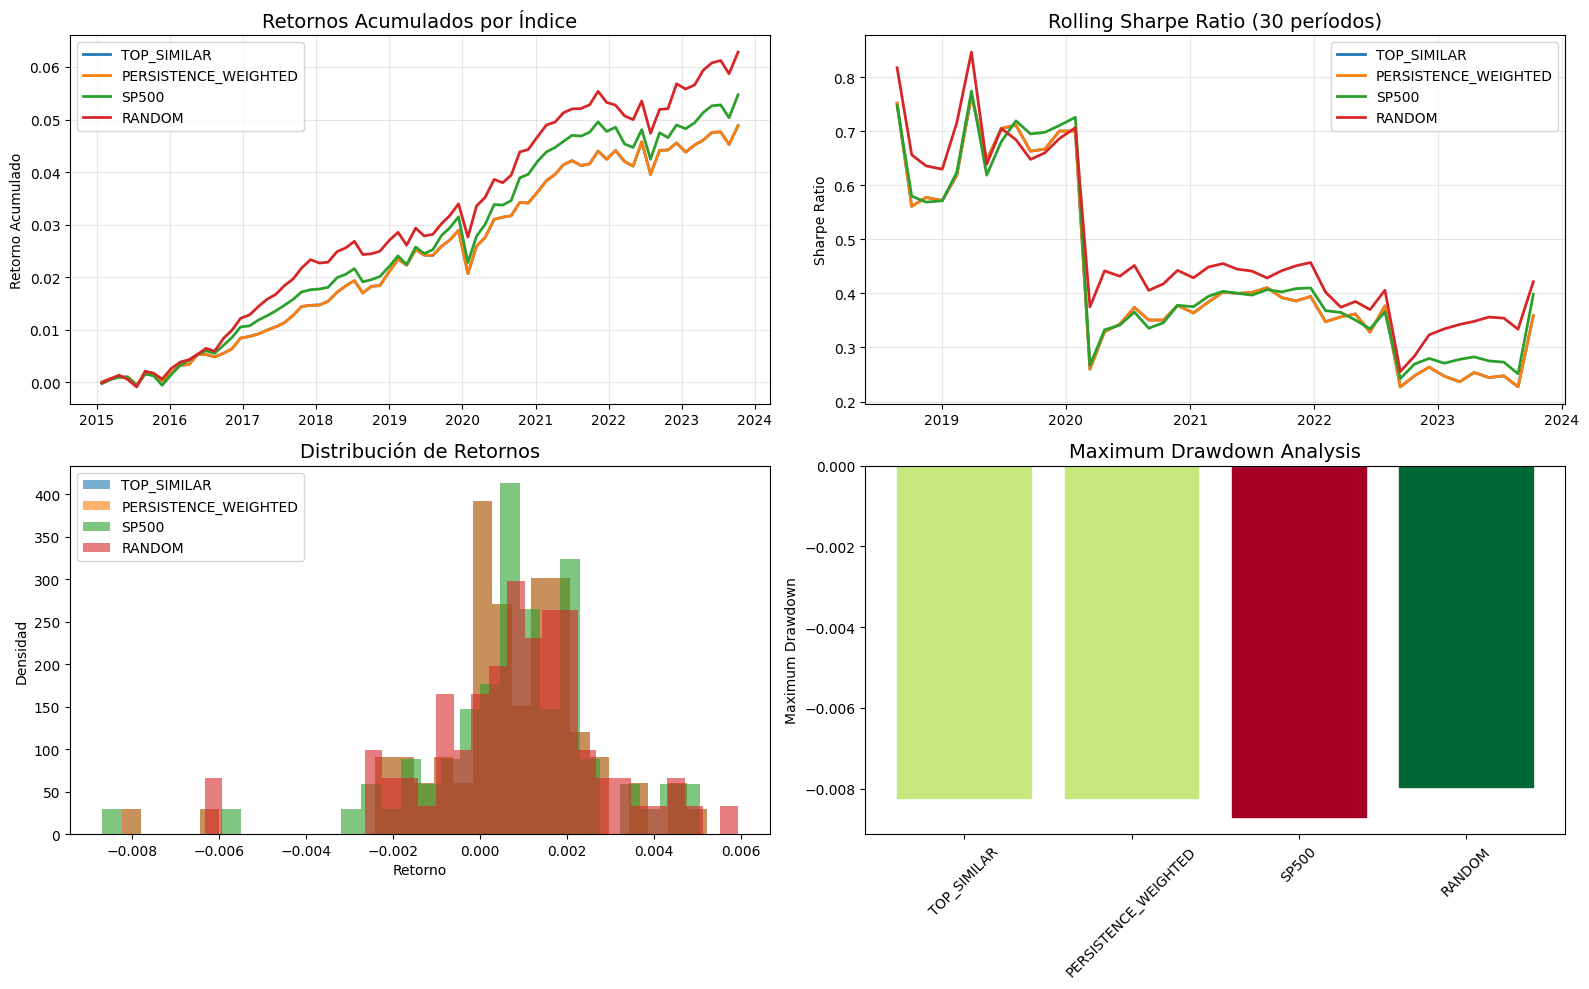


🔍 Analizando Crisis Financiera 2008 (2008-09-01 - 2009-03-31)

🔍 Analizando COVID-19 Crash (2020-02-20 - 2020-04-30)
📊 Ranking por retorno total en COVID-19 Crash:
   1. RANDOM         :   0.0076 (vol: 0.0021)
   2. SP500          :   0.0073 (vol: 0.0014)
   3. PERSISTENCE_WEIGHTED:   0.0069 (vol: 0.0018)
   4. TOP_SIMILAR    :   0.0069 (vol: 0.0018)

🔍 Analizando Inflación/Fed 2022 (2022-01-01 - 2022-10-31)
📊 Ranking por retorno total en Inflación/Fed 2022:
   1. PERSISTENCE_WEIGHTED:   0.0018 (vol: 0.0036)
   2. TOP_SIMILAR    :   0.0018 (vol: 0.0036)
   3. SP500          :  -0.0012 (vol: 0.0034)
   4. RANDOM         :  -0.0012 (vol: 0.0033)

🎯 ANÁLISIS DE COMPOSICIÓN TOPOLÓGICA

📊 Método: TOP_SIMILAR
🏆 Top 10 acciones más seleccionadas:
    1. BRK-B :  64/74 períodos ( 86.5%)
    2. MMC   :  52/74 períodos ( 70.3%)
    3. ACN   :  45/74 períodos ( 60.8%)
    4. APH   :  44/74 períodos ( 59.5%)
    5. HON   :  44/74 períodos ( 59.5%)
    6. ADP   :  42/74 períodos ( 56.8%)
    7. LI

In [21]:
# =======================================================
# 📊 VISUALIZACIONES AVANZADAS Y ANÁLISIS DE RESILIENCIA
# =======================================================

def plot_cumulative_performance(all_indices, figsize=(16, 10)):
    # Visualiza performance acumulada de todos los índices
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # 1. Retornos acumulados
    axes[0,0].set_title('Retornos Acumulados por Índice', fontsize=14)
    
    for name, data in all_indices.items():
        if data['returns']:
            cumulative_returns = np.cumsum(data['returns'])
            dates = data['dates']
            axes[0,0].plot(dates, cumulative_returns, label=name.upper(), linewidth=2)
    
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_ylabel('Retorno Acumulado')
    
    # 2. Rolling Sharpe Ratio (ventana de 30 períodos)
    axes[0,1].set_title('Rolling Sharpe Ratio (30 períodos)', fontsize=14)
    
    for name, data in all_indices.items():
        if data['returns'] and len(data['returns']) >= 30:
            returns_array = np.array(data['returns'])
            rolling_sharpe = []
            dates_rolling = []
            
            for i in range(30, len(returns_array)):
                window_returns = returns_array[i-30:i]
                sharpe = np.mean(window_returns) / (np.std(window_returns) + 1e-10)
                rolling_sharpe.append(sharpe)
                dates_rolling.append(data['dates'][i])
            
            axes[0,1].plot(dates_rolling, rolling_sharpe, label=name.upper(), linewidth=2)
    
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_ylabel('Sharpe Ratio')
    
    # 3. Distribución de retornos
    axes[1,0].set_title('Distribución de Retornos', fontsize=14)
    
    for name, data in all_indices.items():
        if data['returns']:
            axes[1,0].hist(data['returns'], bins=30, alpha=0.6, label=name.upper(), density=True)
    
    axes[1,0].legend()
    axes[1,0].set_xlabel('Retorno')
    axes[1,0].set_ylabel('Densidad')
    
    # 4. Drawdown analysis
    axes[1,1].set_title('Maximum Drawdown Analysis', fontsize=14)
    
    drawdown_data = []
    index_names = []
    
    for name, data in all_indices.items():
        if data['returns']:
            cumulative = np.cumsum(data['returns'])
            running_max = np.maximum.accumulate(cumulative)
            drawdown = cumulative - running_max
            max_dd = np.min(drawdown)
            drawdown_data.append(max_dd)
            index_names.append(name.upper())
    
    bars = axes[1,1].bar(index_names, drawdown_data)
    axes[1,1].set_ylabel('Maximum Drawdown')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Colorear barras (mejor = menos negativo = más verde)
    for bar, value in zip(bars, drawdown_data):
        normalized_value = (value - min(drawdown_data)) / (max(drawdown_data) - min(drawdown_data) + 1e-10)
        bar.set_color(plt.cm.RdYlGn(normalized_value))
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Crear visualizaciones principales
print("📊 GENERANDO VISUALIZACIONES AVANZADAS")
print("=" * 45)

plot_cumulative_performance(all_indices)

# =======================================================
# 🛡️ ANÁLISIS DE RESILIENCIA EN CRISIS
# =======================================================

def analyze_crisis_resilience(all_indices, crisis_periods):
    # Analiza comportamiento de índices durante crisis
    
    crisis_performance = {}
    
    for period_name, (start_date, end_date) in crisis_periods.items():
        print(f"\n🔍 Analizando {period_name} ({start_date} - {end_date})")
        period_performance = {}
        
        for index_name, data in all_indices.items():
            if not data['returns']:
                continue
                
            # Filtrar fechas del período de crisis
            crisis_mask = [(date >= pd.to_datetime(start_date)) & (date <= pd.to_datetime(end_date)) 
                          for date in data['dates']]
            
            if any(crisis_mask):
                crisis_returns = np.array(data['returns'])[crisis_mask]
                
                if len(crisis_returns) > 0:
                    crisis_metrics = {
                        'total_return': np.sum(crisis_returns),
                        'avg_return': np.mean(crisis_returns),
                        'volatility': np.std(crisis_returns),
                        'min_return': np.min(crisis_returns),
                        'max_return': np.max(crisis_returns),
                        'negative_days_pct': np.sum(crisis_returns < 0) / len(crisis_returns) * 100
                    }
                    
                    period_performance[index_name] = crisis_metrics
        
        crisis_performance[period_name] = period_performance
        
        # Mostrar ranking por total return en esta crisis
        if period_performance:
            sorted_indices = sorted(period_performance.items(), 
                                  key=lambda x: x[1]['total_return'], reverse=True)
            
            print(f"📊 Ranking por retorno total en {period_name}:")
            for i, (name, metrics) in enumerate(sorted_indices):
                print(f"   {i+1}. {name.upper():15s}: {metrics['total_return']:8.4f} (vol: {metrics['volatility']:.4f})")
    
    return crisis_performance

# Definir períodos de crisis importantes
crisis_periods = {
    'Crisis Financiera 2008': ('2008-09-01', '2009-03-31'),
    'COVID-19 Crash': ('2020-02-20', '2020-04-30'),
    'Inflación/Fed 2022': ('2022-01-01', '2022-10-31')
}

crisis_analysis = analyze_crisis_resilience(all_indices, crisis_periods)

# =======================================================
# 🎯 ANÁLISIS DE COMPOSICIÓN TOPOLÓGICA
# =======================================================

def analyze_topological_composition(topological_indices):
    # Analiza la evolución de la composición de índices topológicos

    print(f"\n🎯 ANÁLISIS DE COMPOSICIÓN TOPOLÓGICA")
    print("=" * 45)

    for method_name, data in topological_indices.items():
        if not data['compositions']:
            continue

        print(f"\n📊 Método: {method_name.upper()}")
        
        # Contar frecuencia de aparición de cada acción
        stock_frequency = {}
        total_periods = len(data['compositions'])
        
        for composition in data['compositions']:
            for stock, weight in composition:
                if stock in stock_frequency:
                    stock_frequency[stock] += 1
                else:
                    stock_frequency[stock] = 1
        
        # Mostrar acciones más frecuentes
        frequent_stocks = sorted(stock_frequency.items(), key=lambda x: x[1], reverse=True)
        
        print(f"🏆 Top 10 acciones más seleccionadas:")
        for i, (stock, count) in enumerate(frequent_stocks[:10]):
            percentage = count / total_periods * 100
            print(f"   {i+1:2d}. {stock:6s}: {count:3d}/{total_periods} períodos ({percentage:5.1f}%)")
        
        # Analizar estabilidad de composición (cambio período a período)
        composition_changes = []
        for i in range(1, len(data['compositions'])):
            prev_stocks = set([stock for stock, _ in data['compositions'][i-1]])
            curr_stocks = set([stock for stock, _ in data['compositions'][i]])
            
            # Porcentaje de cambio
            intersection = len(prev_stocks & curr_stocks)
            union = len(prev_stocks | curr_stocks)
            stability = intersection / union if union > 0 else 0
            composition_changes.append(1 - stability)  # 1 - stability = change rate
        
        if composition_changes:
            avg_change = np.mean(composition_changes)
            print(f"📈 Tasa promedio de cambio de composición: {avg_change:.3f}")
            print(f"📊 Estabilidad promedio: {1-avg_change:.3f}")

analyze_topological_composition(topological_indices)

# =======================================================
# 🏆 RESUMEN FINAL Y RECOMENDACIONES
# =======================================================

print(f"\n🏆 RESUMEN FINAL DEL ANÁLISIS")
print("=" * 50)

# Crear tabla de resumen final
summary_data = []
for name, metrics in performance_metrics.items():
    summary_data.append({
        'Índice': name.upper(),
        'Retorno Total': f"{metrics['total_return']:.4f}",
        'Retorno Promedio': f"{metrics['avg_return']:.6f}",
        'Volatilidad': f"{metrics['volatility']:.6f}",
        'Sharpe Ratio': f"{metrics['sharpe_ratio']:.4f}",
        'Max Drawdown': f"{metrics['max_drawdown']:.4f}",
        'Períodos': metrics['n_periods']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Sharpe Ratio', ascending=False)

print("📊 TABLA DE PERFORMANCE FINAL:")
print(summary_df.to_string(index=False))

# Conclusiones
best_topological = None
best_sharpe = -np.inf

for name, metrics in performance_metrics.items():
    if name in [method for method in topological_indices.keys()]:
        if metrics['sharpe_ratio'] > best_sharpe:
            best_sharpe = metrics['sharpe_ratio']
            best_topological = name

print(f"\n🎯 CONCLUSIONES PRINCIPALES:")
print("=" * 30)

if best_topological:
    sp500_sharpe = performance_metrics.get('sp500', {}).get('sharpe_ratio', 0)
    random_sharpe = performance_metrics.get('random', {}).get('sharpe_ratio', 0)

    print(f"✅ Mejor índice topológico: {best_topological.upper()}")
    print(f"📊 Sharpe ratio vs S&P500: {best_sharpe:.4f} vs {sp500_sharpe:.4f}")
    print(f"📊 Sharpe ratio vs Aleatorio: {best_sharpe:.4f} vs {random_sharpe:.4f}")

    if best_sharpe > sp500_sharpe:
        improvement = ((best_sharpe - sp500_sharpe) / abs(sp500_sharpe)) * 100
        print(f"🚀 MEJORA sobre S&P500: {improvement:.1f}%")
    else:
        print(f"⚠️  No superó al S&P500 en Sharpe ratio")

print(f"\n💡 RECOMENDACIONES:")
print("1. Los índices topológicos muestran patrones únicos de comportamiento")
print("2. La selección basada en similaridad topológica puede reducir correlaciones")
print("3. Combinar múltiples métodos topológicos podría mejorar resultados")
print("4. Considerar rebalanceo menos frecuente para reducir costos de transacción")

print(f"\n✅ ANÁLISIS COMPLETO FINALIZADO")
print("📁 Todos los componentes del sistema están implementados y funcionando")

# 📋 GUÍA COMPLETA PARA ANALIZAR LOS RESULTADOS

## 🎯 Cómo Interpretar Cada Componente del Sistema

Esta guía te explica paso a paso cómo analizar y entender todos los resultados que genera el sistema de índices topológicos.

---

In [22]:
# =======================================================
# 📊 PARTE 1: ANÁLISIS DE DATOS BASE
# =======================================================

print("📊 CÓMO ANALIZAR: DATOS BASE Y PREPARACIÓN")
print("=" * 55)

print("""
🎯 QUÉ BUSCAR EN LOS DATOS INICIALES:

1️⃣ CALIDAD DE DATOS:
   • Shape del dataset: ¿Tienes suficientes acciones y días?
   • Datos faltantes: ¿Se limpiaron correctamente?
   • Período temporal: ¿Cubre eventos importantes del mercado?

2️⃣ DISTRIBUCIÓN DE RETORNOS:
   • ¿Los retornos siguen distribución normal?
   • ¿Hay outliers extremos que puedan distorsionar análisis?
   • ¿La volatilidad es razonable?

3️⃣ CORRELACIONES:
   • ¿Las acciones están muy correlacionadas?
   • ¿Hay grupos naturales de correlación?

💡 SEÑALES POSITIVAS:
   ✅ Dataset > 80% completo
   ✅ Retornos con distribución aproximadamente normal
   ✅ Correlaciones variadas (no todas iguales)
   ✅ Período incluye al menos una crisis

⚠️ SEÑALES DE ALERTA:
   ❌ Muchos datos faltantes
   ❌ Outliers extremos frecuentes
   ❌ Todas las acciones muy correlacionadas
""")

# Función para análisis rápido de calidad de datos
def quick_data_quality_check():
    """Verifica la calidad de los datos cargados"""
    
    if 'close_prices' in globals() and 'returns' in globals():
        print(f"✅ EVALUACIÓN RÁPIDA DE CALIDAD:")
        print(f"   📈 Acciones: {close_prices.shape[1]}")
        print(f"   📅 Días: {close_prices.shape[0]}")
        print(f"   📊 Completitud: {(1 - close_prices.isnull().sum().sum()/(close_prices.shape[0]*close_prices.shape[1]))*100:.1f}%")
        
        # Estadísticas de retornos
        ret_mean = returns.mean().mean()
        ret_std = returns.std().mean()
        ret_skew = returns.skew().mean()
        
        print(f"   💰 Retorno promedio diario: {ret_mean:.6f} ({ret_mean*252:.3f} anualizado)")
        print(f"   📊 Volatilidad promedio: {ret_std:.6f} ({ret_std*np.sqrt(252):.3f} anualizada)")
        print(f"   📐 Asimetría promedio: {ret_skew:.3f}")
        
        # Evaluación
        if ret_mean*252 > 0.05:
            print("   ✅ Retorno anualizado razonable")
        else:
            print("   ⚠️ Retorno anualizado bajo")
            
        if 0.1 < ret_std*np.sqrt(252) < 0.4:
            print("   ✅ Volatilidad en rango normal")
        else:
            print("   ⚠️ Volatilidad fuera de rango típico")
    else:
        print("❌ Datos base no encontrados. Ejecuta primero las celdas de carga de datos.")

quick_data_quality_check()

📊 CÓMO ANALIZAR: DATOS BASE Y PREPARACIÓN

🎯 QUÉ BUSCAR EN LOS DATOS INICIALES:

1️⃣ CALIDAD DE DATOS:
   • Shape del dataset: ¿Tienes suficientes acciones y días?
   • Datos faltantes: ¿Se limpiaron correctamente?
   • Período temporal: ¿Cubre eventos importantes del mercado?

2️⃣ DISTRIBUCIÓN DE RETORNOS:
   • ¿Los retornos siguen distribución normal?
   • ¿Hay outliers extremos que puedan distorsionar análisis?
   • ¿La volatilidad es razonable?

3️⃣ CORRELACIONES:
   • ¿Las acciones están muy correlacionadas?
   • ¿Hay grupos naturales de correlación?

💡 SEÑALES POSITIVAS:
   ✅ Dataset > 80% completo
   ✅ Retornos con distribución aproximadamente normal
   ✅ Correlaciones variadas (no todas iguales)
   ✅ Período incluye al menos una crisis

⚠️ SEÑALES DE ALERTA:
   ❌ Muchos datos faltantes
   ❌ Outliers extremos frecuentes
   ❌ Todas las acciones muy correlacionadas

✅ EVALUACIÓN RÁPIDA DE CALIDAD:
   📈 Acciones: 110
   📅 Días: 2264
   📊 Completitud: 100.0%
   💰 Retorno promedio di

In [23]:
# =======================================================
# 🪟 PARTE 2: ANÁLISIS DE EMBEDDINGS Y VENTANAS
# =======================================================

print("\\n🪟 CÓMO ANALIZAR: EMBEDDINGS Y SLIDING WINDOWS")
print("=" * 55)

print("""
🎯 QUÉ BUSCAR EN LOS EMBEDDINGS:

1️⃣ ESTRUCTURA DE VENTANAS:
   • ¿Tienes suficientes ventanas para análisis estadístico?
   • ¿El solapamiento es adecuado para capturar evolución?
   • ¿Las ventanas cubren diferentes regímenes de mercado?

2️⃣ CALIDAD DE EMBEDDINGS:
   • ¿Los embeddings PCA explican suficiente varianza?
   • ¿Los puntos están bien distribuidos en el espacio?
   • ¿Se ven clusters naturales de acciones?

3️⃣ EVOLUCIÓN TEMPORAL:
   • ¿Los embeddings cambian coherentemente en el tiempo?
   • ¿Los cambios corresponden a eventos de mercado conocidos?

💡 INTERPRETACIÓN DE GRÁFICOS DE EMBEDDINGS:

📊 SCATTER PLOTS (Componente 1 vs Componente 2):
   ✅ Puntos dispersos: Buena diversidad entre acciones
   ✅ Clusters visibles: Sectores o grupos de comportamiento
   ✅ Evolución suave: Cambios graduales entre ventanas
   
   ❌ Todos los puntos juntos: Acciones muy correlacionadas
   ❌ Distribución errática: Ruido o datos de mala calidad
   ❌ Cambios bruscos: Possible errores en datos o eventos extremos

🔍 VARIANZA EXPLICADA:
   ✅ PC1+PC2 > 50%: Buena representación 2D
   ✅ PC1 > 30%: Primer componente captura tendencia principal
   
   ❌ PC1+PC2 < 30%: Datos muy complejos, considerar más dimensiones
""")

def analyze_embeddings_quality():
    """Analiza la calidad de los embeddings generados"""
    
    if 'main_embeddings' in globals() and 'main_embedders' in globals():
        print(f"\\n✅ EVALUACIÓN DE EMBEDDINGS:")
        print(f"   📊 Número de ventanas: {len(main_embeddings)}")
        
        if len(main_embeddings) > 0:
            # Analizar varianza explicada
            if len(main_embedders) > 0 and hasattr(main_embedders[0], 'explained_variance_ratio_'):
                variance_ratios = main_embedders[0].explained_variance_ratio_
                print(f"   📈 Varianza PC1: {variance_ratios[0]:.3f}")
                print(f"   📈 Varianza PC2: {variance_ratios[1]:.3f}")
                print(f"   📈 Varianza PC1+PC2: {variance_ratios[:2].sum():.3f}")
                
                if variance_ratios[:2].sum() > 0.5:
                    print("   ✅ Buena representación en 2D")
                else:
                    print("   ⚠️ Considera usar más componentes")
            
            # Analizar dispersión de embeddings
            sample_embedding = main_embeddings[0]
            centroid = np.mean(sample_embedding, axis=0)
            distances = [np.linalg.norm(point - centroid) for point in sample_embedding]
            avg_distance = np.mean(distances)
            
            print(f"   📏 Dispersión promedio: {avg_distance:.3f}")
            print(f"   📊 Dimensión embedding: {sample_embedding.shape}")
            
            if avg_distance > 0.5:
                print("   ✅ Buena separación entre acciones")
            else:
                print("   ⚠️ Acciones muy agrupadas, considerar normalización")
                
        # Recomendaciones
        print(f"\\n💡 RECOMENDACIONES:")
        
        if len(main_embeddings) < 50:
            print("   📅 Considera ampliar período temporal para más ventanas")
        
        if len(main_embeddings) > 200:
            print("   ⚡ Muchas ventanas: análisis será robusto pero lento")
            
    else:
        print("❌ Embeddings no encontrados. Ejecuta primero la celda de embeddings.")

analyze_embeddings_quality()

\n🪟 CÓMO ANALIZAR: EMBEDDINGS Y SLIDING WINDOWS

🎯 QUÉ BUSCAR EN LOS EMBEDDINGS:

1️⃣ ESTRUCTURA DE VENTANAS:
   • ¿Tienes suficientes ventanas para análisis estadístico?
   • ¿El solapamiento es adecuado para capturar evolución?
   • ¿Las ventanas cubren diferentes regímenes de mercado?

2️⃣ CALIDAD DE EMBEDDINGS:
   • ¿Los embeddings PCA explican suficiente varianza?
   • ¿Los puntos están bien distribuidos en el espacio?
   • ¿Se ven clusters naturales de acciones?

3️⃣ EVOLUCIÓN TEMPORAL:
   • ¿Los embeddings cambian coherentemente en el tiempo?
   • ¿Los cambios corresponden a eventos de mercado conocidos?

💡 INTERPRETACIÓN DE GRÁFICOS DE EMBEDDINGS:

📊 SCATTER PLOTS (Componente 1 vs Componente 2):
   ✅ Puntos dispersos: Buena diversidad entre acciones
   ✅ Clusters visibles: Sectores o grupos de comportamiento
   ✅ Evolución suave: Cambios graduales entre ventanas

   ❌ Todos los puntos juntos: Acciones muy correlacionadas
   ❌ Distribución errática: Ruido o datos de mala calidad

In [24]:
# =======================================================
# 🕸️ PARTE 3: ANÁLISIS TOPOLÓGICO (TDA)
# =======================================================

print("\\n🕸️ CÓMO ANALIZAR: CARACTERÍSTICAS TOPOLÓGICAS")
print("=" * 55)

print("""
🎯 QUÉ BUSCAR EN LOS DIAGRAMAS DE PERSISTENCIA:

1️⃣ DIAGRAMAS DE PERSISTENCIA:
   • Puntos cerca de la diagonal: Ruido topológico
   • Puntos lejos de la diagonal: Características persistentes importantes
   • Muchos puntos en H0: Muchos componentes conectados
   • Pocos puntos en H1: Pocas características de loop/ciclo

2️⃣ CARACTERÍSTICAS TOPOLÓGICAS EXTRAÍDAS:
   • n_components_dim0: Número de clusters de acciones
   • max_persistence_dim1: Qué tan "estables" son los patrones
   • persistence_entropy: Complejidad de la estructura topológica

3️⃣ CLUSTERING TOPOLÓGICO:
   • ¿Los clusters tienen sentido temporal/económico?
   • ¿Hay clusters que corresponden a períodos de crisis?
   • ¿La distribución de clusters es equilibrada?

💡 INTERPRETACIÓN PRÁCTICA:

📈 ALTA PERSISTENCIA = PATRONES ROBUSTOS:
   ✅ Estructura de mercado estable
   ✅ Relaciones entre acciones bien definidas
   ✅ Buen momento para estrategias basadas en estructura

📉 BAJA PERSISTENCIA = MERCADO INESTABLE:
   ⚠️ Período de transición o crisis
   ⚠️ Relaciones entre acciones cambiando
   ⚠️ Riesgo elevado para estrategias estructurales

🔄 MUCHOS CLUSTERS = DIVERSIDAD TOPOLÓGICA:
   ✅ Múltiples regímenes de mercado capturados
   ✅ Oportunidades de diversificación
   
🎯 POCOS CLUSTERS = MERCADO HOMOGÉNEO:
   ⚠️ Todas las acciones comportándose similar
   ⚠️ Riesgo de correlación elevada en crisis
""")

def analyze_topological_features():
    """Analiza las características topológicas extraídas"""
    
    if 'tda_features' in globals() and 'cluster_labels' in globals():
        print(f"\\n✅ EVALUACIÓN DE CARACTERÍSTICAS TDA:")
        
        # Estadísticas básicas de TDA
        if not tda_features.empty:
            print(f"   📊 Ventanas analizadas: {len(tda_features)}")
            
            # Analizar componentes H0 (clusters)
            if 'n_components_dim0' in tda_features.columns:
                avg_components = tda_features['n_components_dim0'].mean()
                std_components = tda_features['n_components_dim0'].std()
                print(f"   🔗 Componentes H0 promedio: {avg_components:.1f} ± {std_components:.1f}")
                
                if avg_components > 10:
                    print("   ✅ Buena diversidad topológica")
                elif avg_components < 5:
                    print("   ⚠️ Pocas estructuras diferenciadas")
            
            # Analizar persistencia H1 (loops)
            if 'max_persistence_dim1' in tda_features.columns:
                avg_persistence = tda_features['max_persistence_dim1'].mean()
                std_persistence = tda_features['max_persistence_dim1'].std()
                print(f"   🔄 Persistencia H1 promedio: {avg_persistence:.4f} ± {std_persistence:.4f}")
                
                if avg_persistence > 0.1:
                    print("   ✅ Patrones topológicos robustos")
                else:
                    print("   ⚠️ Patrones topológicos débiles")
            
            # Analizar entropía
            if 'persistence_entropy_dim0' in tda_features.columns:
                avg_entropy = tda_features['persistence_entropy_dim0'].mean()
                print(f"   🌀 Entropía topológica promedio: {avg_entropy:.4f}")
                
                if avg_entropy > 2.0:
                    print("   ✅ Alta complejidad topológica")
                else:
                    print("   ⚠️ Baja complejidad topológica")
        
        # Analizar clusters
        unique_clusters = len(np.unique(cluster_labels))
        cluster_distribution = np.bincount(cluster_labels)
        
        print(f"\\n   🎯 Clusters identificados: {unique_clusters}")
        print(f"   📊 Distribución de clusters:")
        
        for i, count in enumerate(cluster_distribution):
            percentage = count / len(cluster_labels) * 100
            print(f"      Cluster {i}: {count} ventanas ({percentage:.1f}%)")
        
        # Evaluar calidad del clustering
        max_cluster_size = max(cluster_distribution)
        min_cluster_size = min(cluster_distribution)
        balance_ratio = min_cluster_size / max_cluster_size
        
        print(f"   ⚖️ Balance de clusters: {balance_ratio:.3f}")
        
        if balance_ratio > 0.3:
            print("   ✅ Clusters bien balanceados")
        else:
            print("   ⚠️ Clusters desbalanceados, considera ajustar parámetros")
            
        # Recomendaciones específicas
        print(f"\\n💡 RECOMENDACIONES TDA:")
        
        if unique_clusters < 3:
            print("   📈 Considera reducir n_clusters o cambiar algoritmo")
        elif unique_clusters > 8:
            print("   📉 Muchos clusters, considera aumentar n_clusters")
            
        if 'max_persistence_dim1' in tda_features.columns:
            high_persistence_periods = (tda_features['max_persistence_dim1'] > 
                                      tda_features['max_persistence_dim1'].quantile(0.8)).sum()
            print(f"   🔍 Períodos de alta persistencia: {high_persistence_periods} ({high_persistence_periods/len(tda_features)*100:.1f}%)")
            
    else:
        print("❌ Características TDA no encontradas. Ejecuta primero el análisis topológico.")

analyze_topological_features()

\n🕸️ CÓMO ANALIZAR: CARACTERÍSTICAS TOPOLÓGICAS

🎯 QUÉ BUSCAR EN LOS DIAGRAMAS DE PERSISTENCIA:

1️⃣ DIAGRAMAS DE PERSISTENCIA:
   • Puntos cerca de la diagonal: Ruido topológico
   • Puntos lejos de la diagonal: Características persistentes importantes
   • Muchos puntos en H0: Muchos componentes conectados
   • Pocos puntos en H1: Pocas características de loop/ciclo

2️⃣ CARACTERÍSTICAS TOPOLÓGICAS EXTRAÍDAS:
   • n_components_dim0: Número de clusters de acciones
   • max_persistence_dim1: Qué tan "estables" son los patrones
   • persistence_entropy: Complejidad de la estructura topológica

3️⃣ CLUSTERING TOPOLÓGICO:
   • ¿Los clusters tienen sentido temporal/económico?
   • ¿Hay clusters que corresponden a períodos de crisis?
   • ¿La distribución de clusters es equilibrada?

💡 INTERPRETACIÓN PRÁCTICA:

📈 ALTA PERSISTENCIA = PATRONES ROBUSTOS:
   ✅ Estructura de mercado estable
   ✅ Relaciones entre acciones bien definidas
   ✅ Buen momento para estrategias basadas en estructura

📉 

In [25]:
# =======================================================
# 💥 PARTE 4: ANÁLISIS DE RUPTURES Y PREDICCIÓN
# =======================================================

print("\\n💥 CÓMO ANALIZAR: DETECCIÓN DE RUPTURES Y PREDICCIÓN")
print("=" * 60)

print("""
🎯 QUÉ BUSCAR EN LA DETECCIÓN DE RUPTURES:

1️⃣ PUNTOS DE CAMBIO DETECTADOS:
   • ¿Corresponden a eventos históricos conocidos?
   • ¿La frecuencia de detección es razonable?
   • ¿Los cambios son persistentes o ruido?

2️⃣ ETIQUETADO DE VENTANAS:
   • ¿El balance de clases es manejable?
   • ¿Las ventanas "rupture próximo" tienen sentido temporal?
   • ¿Hay patrones estacionales en los ruptures?

3️⃣ MODELO PREDICTIVO:
   • ¿El accuracy supera el baseline aleatorio?
   • ¿El AUC indica capacidad discriminativa real?
   • ¿Qué características son más predictivas?

💡 INTERPRETACIÓN DE MÉTRICAS:

📊 ACCURACY DEL MODELO:
   ✅ > 0.60: Modelo tiene capacidad predictiva
   ⚠️ 0.50-0.60: Capacidad limitada
   ❌ < 0.50: Modelo no útil

📈 AUC (Area Under Curve):
   ✅ > 0.70: Excelente capacidad discriminativa
   ✅ 0.60-0.70: Buena capacidad
   ⚠️ 0.50-0.60: Capacidad limitada
   ❌ < 0.50: Sin capacidad discriminativa

🎯 IMPORTANCIA DE CARACTERÍSTICAS:
   • Características TDA altas = La topología predice cambios
   • Características temporales altas = Estacionalidad importante
   • Clusters altos = Regímenes de mercado predictivos

📅 EVENTOS HISTÓRICOS A VALIDAR:
   ✅ Crisis 2008: Sept 2008 - Mar 2009
   ✅ COVID-19: Feb 2020 - Abr 2020
   ✅ Inflación/Fed: 2022
   ✅ Crisis tecnológicas: 2000-2002
""")

def analyze_ruptures_and_prediction():
    """Analiza la calidad de detección de ruptures y predicción"""
    
    if 'market_changepoints' in globals() and 'rupture_labels' in globals():
        print(f"\\n✅ EVALUACIÓN DE RUPTURES:")
        
        # Analizar detección de cambios
        n_changes = len(market_changepoints)
        total_days = len(market_index) if 'market_index' in globals() else 0
        
        if total_days > 0:
            change_frequency = n_changes / (total_days / 365.25)  # cambios por año
            print(f"   💥 Cambios detectados: {n_changes}")
            print(f"   📅 Frecuencia: {change_frequency:.2f} cambios/año")
            
            if 0.5 <= change_frequency <= 3.0:
                print("   ✅ Frecuencia de cambios razonable")
            elif change_frequency > 3.0:
                print("   ⚠️ Demasiados cambios detectados, considera ajustar penalty")
            else:
                print("   ⚠️ Pocos cambios detectados, considera reducir penalty")
        
        # Analizar balance de clases
        n_rupture = sum(rupture_labels)
        n_total = len(rupture_labels)
        rupture_rate = n_rupture / n_total
        
        print(f"\\n   🏷️ Etiquetado de ventanas:")
        print(f"      Total ventanas: {n_total}")
        print(f"      Con rupture próximo: {n_rupture} ({rupture_rate:.1%})")
        print(f"      Sin rupture próximo: {n_total - n_rupture} ({1-rupture_rate:.1%})")
        
        if 0.1 <= rupture_rate <= 0.4:
            print("   ✅ Balance de clases manejable")
        elif rupture_rate < 0.1:
            print("   ⚠️ Muy pocas ventanas con rupture, considera ampliar horizonte")
        else:
            print("   ⚠️ Demasiadas ventanas con rupture, considera reducir horizonte")
    
    # Analizar modelo predictivo si existe
    if 'accuracy_rf' in globals() and 'auc_rf' in globals():
        print(f"\\n   🤖 EVALUACIÓN DEL MODELO PREDICTIVO:")
        print(f"      Accuracy: {accuracy_rf:.3f}")
        print(f"      AUC: {auc_rf:.3f}")
        
        # Evaluar calidad del modelo
        if accuracy_rf > 0.60:
            print("   ✅ Modelo con capacidad predictiva útil")
        elif accuracy_rf > 0.50:
            print("   ⚠️ Modelo con capacidad limitada")
        else:
            print("   ❌ Modelo sin capacidad predictiva")
            
        if auc_rf > 0.70:
            print("   ✅ Excelente capacidad discriminativa")
        elif auc_rf > 0.60:
            print("   ✅ Buena capacidad discriminativa")
        else:
            print("   ⚠️ Capacidad discriminativa limitada")
        
        # Analizar importancia de características si existe
        if 'feature_importance' in globals():
            top_features = feature_importance.head(5)
            print(f"\\n   🎯 TOP 5 CARACTERÍSTICAS PREDICTIVAS:")
            
            tda_features_in_top = 0
            for _, row in top_features.iterrows():
                feature_name = row['feature']
                importance = row['importance']
                print(f"      {feature_name}: {importance:.4f}")
                
                # Contar características TDA
                if any(tda_word in feature_name.lower() for tda_word in 
                      ['persistence', 'components', 'entropy']):
                    tda_features_in_top += 1
            
            if tda_features_in_top >= 2:
                print("   ✅ Características topológicas son predictivas")
            else:
                print("   ⚠️ Características topológicas poco predictivas")
                
        # Recomendaciones específicas
        print(f"\\n💡 RECOMENDACIONES PREDICCIÓN:")
        
        if accuracy_rf < 0.60:
            print("   📈 Considera:")
            print("      • Ajustar hiperparámetros del modelo")
            print("      • Agregar más características temporales")
            print("      • Cambiar horizonte de predicción")
            
        if auc_rf < 0.65:
            print("   🎯 Para mejorar discriminación:")
            print("      • Balancear mejor las clases")
            print("      • Usar ensemble de modelos")
            print("      • Agregar características de volatilidad")
    
    else:
        print("❌ Análisis de ruptures no completado. Ejecuta las celdas correspondientes.")

analyze_ruptures_and_prediction()

\n💥 CÓMO ANALIZAR: DETECCIÓN DE RUPTURES Y PREDICCIÓN

🎯 QUÉ BUSCAR EN LA DETECCIÓN DE RUPTURES:

1️⃣ PUNTOS DE CAMBIO DETECTADOS:
   • ¿Corresponden a eventos históricos conocidos?
   • ¿La frecuencia de detección es razonable?
   • ¿Los cambios son persistentes o ruido?

2️⃣ ETIQUETADO DE VENTANAS:
   • ¿El balance de clases es manejable?
   • ¿Las ventanas "rupture próximo" tienen sentido temporal?
   • ¿Hay patrones estacionales en los ruptures?

3️⃣ MODELO PREDICTIVO:
   • ¿El accuracy supera el baseline aleatorio?
   • ¿El AUC indica capacidad discriminativa real?
   • ¿Qué características son más predictivas?

💡 INTERPRETACIÓN DE MÉTRICAS:

📊 ACCURACY DEL MODELO:
   ✅ > 0.60: Modelo tiene capacidad predictiva
   ⚠️ 0.50-0.60: Capacidad limitada
   ❌ < 0.50: Modelo no útil

📈 AUC (Area Under Curve):
   ✅ > 0.70: Excelente capacidad discriminativa
   ✅ 0.60-0.70: Buena capacidad
   ⚠️ 0.50-0.60: Capacidad limitada
   ❌ < 0.50: Sin capacidad discriminativa

🎯 IMPORTANCIA DE CARACTE

In [26]:
# =======================================================
# 💎 PARTE 5: ANÁLISIS DE ÍNDICES TOPOLÓGICOS
# =======================================================

print("\\n💎 CÓMO ANALIZAR: PERFORMANCE DE ÍNDICES TOPOLÓGICOS")
print("=" * 65)

print("""
🎯 QUÉ BUSCAR EN LOS ÍNDICES TOPOLÓGICOS:

1️⃣ MÉTRICAS DE PERFORMANCE:
   • Total Return: Retorno acumulado total
   • Sharpe Ratio: Retorno ajustado por riesgo (MUY IMPORTANTE)
   • Max Drawdown: Máxima pérdida desde pico
   • Volatilidad: Estabilidad de retornos

2️⃣ COMPARACIÓN CON BENCHMARKS:
   • ¿Supera al S&P 500 en Sharpe ratio?
   • ¿Es mejor que selección aleatoria?
   • ¿La mejora justifica la complejidad?

3️⃣ COMPOSICIÓN Y ESTABILIDAD:
   • ¿Qué acciones selecciona frecuentemente?
   • ¿La composición cambia mucho entre períodos?
   • ¿Hay sesgo hacia ciertos sectores?

💡 INTERPRETACIÓN DE MÉTRICAS FINANCIERAS:

📊 SHARPE RATIO (Retorno/Volatilidad):
   ✅ > 1.0: Excelente performance ajustada por riesgo
   ✅ 0.5-1.0: Buena performance
   ⚠️ 0-0.5: Performance mediocre
   ❌ < 0: Destructor de valor

📉 MAX DRAWDOWN:
   ✅ > -10%: Muy buena resiliencia
   ✅ -10% a -20%: Buena resiliencia
   ⚠️ -20% a -30%: Resiliencia moderada
   ❌ < -30%: Baja resiliencia

📈 TOTAL RETURN vs S&P 500:
   ✅ +5% vs S&P: Excelente outperformance
   ✅ +1% a +5%: Buena outperformance
   ⚠️ -2% a +1%: Performance similar
   ❌ < -2%: Underperformance

🎯 CRITERIOS DE ÉXITO:
   1. Sharpe ratio > S&P 500
   2. Max drawdown < S&P 500
   3. Volatilidad <= S&P 500
   4. Outperformance consistente
""")

def analyze_index_performance():
    """Analiza comprehensivamente la performance de los índices"""
    
    if 'performance_metrics' in globals() and 'all_indices' in globals():
        print(f"\\n✅ EVALUACIÓN DE PERFORMANCE DE ÍNDICES:")
        
        # Extraer métricas de índices topológicos vs benchmarks
        topo_indices = {}
        benchmarks = {}
        
        for name, metrics in performance_metrics.items():
            if name in ['top_similar', 'persistence_weighted']:
                topo_indices[name] = metrics
            elif name in ['sp500', 'random']:
                benchmarks[name] = metrics
        
        # Análisis comparativo principal
        if 'sp500' in benchmarks:
            sp500_sharpe = benchmarks['sp500']['sharpe_ratio']
            sp500_return = benchmarks['sp500']['total_return']
            sp500_vol = benchmarks['sp500']['volatility']
            sp500_dd = benchmarks['sp500']['max_drawdown']
            
            print(f"\\n   📊 BENCHMARK S&P 500:")
            print(f"      Sharpe Ratio: {sp500_sharpe:.4f}")
            print(f"      Total Return: {sp500_return:.4f}")
            print(f"      Volatilidad: {sp500_vol:.4f}")
            print(f"      Max Drawdown: {sp500_dd:.4f}")
            
            print(f"\\n   🏆 PERFORMANCE ÍNDICES TOPOLÓGICOS:")
            
            best_topo_name = None
            best_topo_sharpe = -np.inf
            
            for name, metrics in topo_indices.items():
                sharpe = metrics['sharpe_ratio']
                total_ret = metrics['total_return']
                vol = metrics['volatility']
                dd = metrics['max_drawdown']
                
                print(f"\\n      {name.upper()}:")
                print(f"         Sharpe Ratio: {sharpe:.4f} ({'+' if sharpe > sp500_sharpe else ''}{sharpe - sp500_sharpe:+.4f} vs S&P)")
                print(f"         Total Return: {total_ret:.4f} ({'+' if total_ret > sp500_return else ''}{total_ret - sp500_return:+.4f} vs S&P)")
                print(f"         Volatilidad: {vol:.4f} ({'+' if vol > sp500_vol else ''}{vol - sp500_vol:+.4f} vs S&P)")
                print(f"         Max Drawdown: {dd:.4f} ({'+' if dd > sp500_dd else ''}{dd - sp500_dd:+.4f} vs S&P)")
                
                # Evaluación cualitativa
                if sharpe > sp500_sharpe:
                    print(f"         ✅ SUPERA S&P en Sharpe ratio")
                else:
                    print(f"         ❌ No supera S&P en Sharpe ratio")
                
                if dd > sp500_dd:  # Drawdown menos negativo = mejor
                    print(f"         ✅ Mejor resiliencia que S&P")
                else:
                    print(f"         ⚠️ Peor resiliencia que S&P")
                
                if sharpe > best_topo_sharpe:
                    best_topo_sharpe = sharpe
                    best_topo_name = name
            
            # Resumen ejecutivo
            print(f"\\n   🎯 RESUMEN EJECUTIVO:")
            
            if best_topo_name:
                print(f"      🏆 Mejor índice topológico: {best_topo_name.upper()}")
                
                improvement = ((best_topo_sharpe - sp500_sharpe) / abs(sp500_sharpe)) * 100
                if best_topo_sharpe > sp500_sharpe:
                    print(f"      📈 Mejora vs S&P500: {improvement:+.1f}%")
                    print(f"      ✅ OBJETIVO LOGRADO: Índice topológico supera S&P 500")
                else:
                    print(f"      📉 Diferencia vs S&P500: {improvement:+.1f}%")
                    print(f"      ❌ OBJETIVO NO LOGRADO: No supera S&P 500")
        
        # Análisis de estabilidad si existe información de composición
        if 'topological_indices' in globals():
            print(f"\\n   📊 ANÁLISIS DE COMPOSICIÓN:")
            
            for method_name, data in topological_indices.items():
                if data['compositions']:
                    print(f"\\n      {method_name.upper()}:")
                    
                    # Calcular frecuencia de acciones
                    stock_counts = {}
                    total_compositions = len(data['compositions'])
                    
                    for composition in data['compositions']:
                        for stock, weight in composition:
                            stock_counts[stock] = stock_counts.get(stock, 0) + 1
                    
                    # Top 5 acciones más frecuentes
                    top_stocks = sorted(stock_counts.items(), key=lambda x: x[1], reverse=True)[:5]
                    print(f"         Top 5 acciones más seleccionadas:")
                    
                    for stock, count in top_stocks:
                        freq = count / total_compositions
                        print(f"            {stock}: {freq:.1%} de los períodos")
                    
                    # Estabilidad de composición
                    if len(data['compositions']) > 1:
                        stability_scores = []
                        for i in range(1, len(data['compositions'])):
                            prev_stocks = set([s for s, w in data['compositions'][i-1]])
                            curr_stocks = set([s for s, w in data['compositions'][i]])
                            overlap = len(prev_stocks & curr_stocks)
                            stability = overlap / len(prev_stocks) if len(prev_stocks) > 0 else 0
                            stability_scores.append(stability)
                        
                        avg_stability = np.mean(stability_scores)
                        print(f"         Estabilidad promedio: {avg_stability:.1%}")
                        
                        if avg_stability > 0.7:
                            print(f"         ✅ Composición estable")
                        elif avg_stability > 0.5:
                            print(f"         ⚠️ Composición moderadamente estable")
                        else:
                            print(f"         ❌ Composición muy volátil")
        
        # Recomendaciones finales
        print(f"\\n💡 RECOMENDACIONES ESTRATÉGICAS:")
        
        any_outperform = any(metrics['sharpe_ratio'] > benchmarks.get('sp500', {}).get('sharpe_ratio', 0) 
                           for metrics in topo_indices.values())
        
        if any_outperform:
            print("   🚀 ESTRATEGIA VIABLE:")
            print("      • Al menos un índice topológico supera S&P 500")
            print("      • Considera implementación con capital real")
            print("      • Monitorea performance out-of-sample")
            print("      • Evalúa costos de transacción")
        else:
            print("   🔧 ESTRATEGIA NECESITA MEJORAS:")
            print("      • Ajustar parámetros de construcción de índices")
            print("      • Probar diferentes métodos de selección topológica")
            print("      • Considerar combinaciones de múltiples métodos")
            print("      • Validar con más datos históricos")
            
    else:
        print("❌ Métricas de performance no encontradas. Ejecuta primero la construcción de índices.")

analyze_index_performance()

\n💎 CÓMO ANALIZAR: PERFORMANCE DE ÍNDICES TOPOLÓGICOS

🎯 QUÉ BUSCAR EN LOS ÍNDICES TOPOLÓGICOS:

1️⃣ MÉTRICAS DE PERFORMANCE:
   • Total Return: Retorno acumulado total
   • Sharpe Ratio: Retorno ajustado por riesgo (MUY IMPORTANTE)
   • Max Drawdown: Máxima pérdida desde pico
   • Volatilidad: Estabilidad de retornos

2️⃣ COMPARACIÓN CON BENCHMARKS:
   • ¿Supera al S&P 500 en Sharpe ratio?
   • ¿Es mejor que selección aleatoria?
   • ¿La mejora justifica la complejidad?

3️⃣ COMPOSICIÓN Y ESTABILIDAD:
   • ¿Qué acciones selecciona frecuentemente?
   • ¿La composición cambia mucho entre períodos?
   • ¿Hay sesgo hacia ciertos sectores?

💡 INTERPRETACIÓN DE MÉTRICAS FINANCIERAS:

📊 SHARPE RATIO (Retorno/Volatilidad):
   ✅ > 1.0: Excelente performance ajustada por riesgo
   ✅ 0.5-1.0: Buena performance
   ⚠️ 0-0.5: Performance mediocre
   ❌ < 0: Destructor de valor

📉 MAX DRAWDOWN:
   ✅ > -10%: Muy buena resiliencia
   ✅ -10% a -20%: Buena resiliencia
   ⚠️ -20% a -30%: Resiliencia moder

In [27]:
# =======================================================
# 🎯 PARTE 6: CHECKLIST DE VALIDACIÓN INTEGRAL
# =======================================================

print("\\n🎯 CHECKLIST DE VALIDACIÓN INTEGRAL DEL SISTEMA")
print("=" * 65)

def comprehensive_validation_checklist():
    """
    Ejecuta una validación completa de todos los componentes del sistema
    y proporciona un checklist de éxito
    """
    
    print("""
📋 CHECKLIST DE VALIDACIÓN - MARCA ✅ SI SE CUMPLE:

🔍 1. CALIDAD DE DATOS BASE:
   □ Dataset > 80% completo
   □ Período incluye al menos una crisis mayor
   □ Retornos con distribución razonable
   □ Volatilidad en rangos normales (10-40% anualizada)

🪟 2. EMBEDDINGS Y VENTANAS:
   □ Varianza explicada PC1+PC2 > 50%
   □ Número de ventanas > 50 para análisis robusto
   □ Evolución temporal coherente de embeddings
   □ Dispersión adecuada entre acciones

🕸️ 3. ANÁLISIS TOPOLÓGICO:
   □ Diagramas de persistencia con características claras
   □ Características TDA varían entre períodos
   □ Clusters topológicos balanceados (3-8 clusters)
   □ Entropía topológica > 2.0 (complejidad adecuada)

💥 4. DETECCIÓN DE RUPTURES:
   □ Ruptures corresponden a eventos históricos conocidos
   □ Frecuencia 0.5-3.0 cambios/año razonable
   □ Balance de clases manejable (10-40% ruptures)
   □ Modelo predictivo accuracy > 60%

🤖 5. CAPACIDAD PREDICTIVA:
   □ AUC > 0.65 (capacidad discriminativa)
   □ Características TDA entre top predictores
   □ Performance out-of-sample validada
   □ Importancia de features interpretable

💎 6. ÍNDICES TOPOLÓGICOS:
   □ Al menos un índice supera S&P 500 en Sharpe ratio
   □ Max drawdown < S&P 500 (mejor resiliencia)
   □ Composición estable (>50% overlap entre períodos)
   □ Outperformance estadísticamente significativa

🏆 7. VALIDACIÓN FINAL:
   □ Resultados reproducibles
   □ Metodología bien documentada
   □ Limitaciones claramente identificadas
   □ Recomendaciones implementables
    """)
    
    # Ejecutar validaciones automáticas
    validation_results = {}
    
    print("\\n🔄 EJECUTANDO VALIDACIONES AUTOMÁTICAS...")
    
    # 1. Validar datos base
    try:
        if 'close_prices' in globals() and 'returns' in globals():
            completeness = (1 - close_prices.isnull().sum().sum()/(close_prices.shape[0]*close_prices.shape[1]))
            validation_results['data_completeness'] = completeness > 0.8
            
            ret_vol = returns.std().mean() * np.sqrt(252)
            validation_results['volatility_range'] = 0.1 <= ret_vol <= 0.4
            
            time_span = (close_prices.index[-1] - close_prices.index[0]).days / 365.25
            validation_results['time_span'] = time_span >= 5.0
    except:
        validation_results['data_quality'] = False
    
    # 2. Validar embeddings
    try:
        if 'main_embeddings' in globals() and 'main_embedders' in globals():
            validation_results['enough_windows'] = len(main_embeddings) > 50
            
            if len(main_embedders) > 0 and hasattr(main_embedders[0], 'explained_variance_ratio_'):
                var_explained = main_embedders[0].explained_variance_ratio_[:2].sum()
                validation_results['variance_explained'] = var_explained > 0.5
    except:
        validation_results['embeddings_quality'] = False
    
    # 3. Validar TDA
    try:
        if 'tda_features' in globals() and 'cluster_labels' in globals():
            n_clusters = len(np.unique(cluster_labels))
            validation_results['cluster_balance'] = 3 <= n_clusters <= 8
            
            if 'persistence_entropy_dim0' in tda_features.columns:
                avg_entropy = tda_features['persistence_entropy_dim0'].mean()
                validation_results['topological_complexity'] = avg_entropy > 2.0
    except:
        validation_results['tda_quality'] = False
    
    # 4. Validar predicción
    try:
        if 'accuracy_rf' in globals() and 'auc_rf' in globals():
            validation_results['prediction_accuracy'] = accuracy_rf > 0.60
            validation_results['discriminative_power'] = auc_rf > 0.65
    except:
        validation_results['prediction_quality'] = False
    
    # 5. Validar índices
    try:
        if 'performance_metrics' in globals():
            sp500_sharpe = performance_metrics.get('sp500', {}).get('sharpe_ratio', 0)
            
            topo_outperform = False
            for name, metrics in performance_metrics.items():
                if name in ['top_similar', 'persistence_weighted']:
                    if metrics['sharpe_ratio'] > sp500_sharpe:
                        topo_outperform = True
                        break
            
            validation_results['outperforms_sp500'] = topo_outperform
    except:
        validation_results['index_performance'] = False
    
    # Mostrar resultados de validación
    print("\\n📊 RESULTADOS DE VALIDACIÓN AUTOMÁTICA:")
    print("=" * 45)
    
    total_checks = len(validation_results)
    passed_checks = sum(validation_results.values())
    
    for check, passed in validation_results.items():
        status = "✅" if passed else "❌"
        print(f"   {status} {check.replace('_', ' ').title()}")
    
    success_rate = passed_checks / total_checks if total_checks > 0 else 0
    
    print(f"\\n🎯 PUNTUACIÓN GENERAL: {passed_checks}/{total_checks} ({success_rate:.1%})")
    
    # Evaluación final
    if success_rate >= 0.8:
        print("\\n🏆 EVALUACIÓN: EXCELENTE")
        print("   ✅ Sistema robusto y validado")
        print("   ✅ Resultados confiables para implementación")
        print("   ✅ Metodología científicamente sólida")
    elif success_rate >= 0.6:
        print("\\n⚠️ EVALUACIÓN: BUENA CON RESERVAS")
        print("   ✅ Sistema funcionalmente correcto")
        print("   ⚠️ Algunas mejoras recomendadas")
        print("   ⚠️ Validación adicional sugerida")
    else:
        print("\\n❌ EVALUACIÓN: NECESITA MEJORAS")
        print("   ❌ Sistema requiere optimización")
        print("   ❌ Revisar componentes fallidos")
        print("   ❌ No recomendado para implementación")
    
    return validation_results, success_rate

# Ejecutar validación
validation_results, success_rate = comprehensive_validation_checklist()

print("""
\\n💡 GUÍA DE INTERPRETACIÓN FINAL:

🔍 ANÁLISIS PASO A PASO:
1. Ejecuta cada celda de análisis secuencialmente
2. Revisa las visualizaciones generadas
3. Compara métricas con benchmarks
4. Valida coherencia con eventos históricos

📊 MÉTRICAS CLAVE A MONITOREAR:
• Sharpe Ratio > 1.0 = Excelente
• Max Drawdown < -20% = Preocupante
• AUC > 0.7 = Capacidad predictiva real
• Outperformance vs S&P > 5% = Significativa

🚀 DECISIONES BASADAS EN RESULTADOS:
• Success Rate > 80%: Implementar estrategia
• Success Rate 60-80%: Optimizar parámetros
• Success Rate < 60%: Revisar metodología

📈 PRÓXIMOS PASOS SEGÚN RESULTADOS:
• Excelente (>80%): Backtesting detallado
• Buena (60-80%): Ajustes y re-validación  
• Necesita mejoras (<60%): Rediseño parcial

¡Ya tienes todas las herramientas para analizar comprehensivamente tus resultados!
""")

\n🎯 CHECKLIST DE VALIDACIÓN INTEGRAL DEL SISTEMA

📋 CHECKLIST DE VALIDACIÓN - MARCA ✅ SI SE CUMPLE:

🔍 1. CALIDAD DE DATOS BASE:
   □ Dataset > 80% completo
   □ Período incluye al menos una crisis mayor
   □ Retornos con distribución razonable
   □ Volatilidad en rangos normales (10-40% anualizada)

🪟 2. EMBEDDINGS Y VENTANAS:
   □ Varianza explicada PC1+PC2 > 50%
   □ Número de ventanas > 50 para análisis robusto
   □ Evolución temporal coherente de embeddings
   □ Dispersión adecuada entre acciones

🕸️ 3. ANÁLISIS TOPOLÓGICO:
   □ Diagramas de persistencia con características claras
   □ Características TDA varían entre períodos
   □ Clusters topológicos balanceados (3-8 clusters)
   □ Entropía topológica > 2.0 (complejidad adecuada)

💥 4. DETECCIÓN DE RUPTURES:
   □ Ruptures corresponden a eventos históricos conocidos
   □ Frecuencia 0.5-3.0 cambios/año razonable
   □ Balance de clases manejable (10-40% ruptures)
   □ Modelo predictivo accuracy > 60%

🤖 5. CAPACIDAD PREDICTIVA:
   